# Dynamic interventions and probabilities of causation in a Bayesian Holling-Tanner fishery model

## Table of Contents

- [Motivations and setup](#motivations-and-setup)
- [Fishery model](#fishery-model)
  - [Trajectories under full fishing/no fishing regimes](#trajectories-under-full-fishingno-fishing-regimes)
  - [Incorporate interventions and uncertainty about model parameters](#incorporate-interventions-and-uncertainty-about-model-parameters)
- [Probabilities of causation](#probabilities-of-causation)
  - [Probabilities of Causation Total Allowable Catch (TAC) Quotas](#probabilities-of-causation-total-allowable-catch-tac-quotas)
  - [Probability of Necessity of State-Dependent Intervention Timing](#probability-of-necessity-of-state-dependent-intervention-timing)


## [Motivations and setup](#motivations-and-setup)


Continuous-time dynamical systems are powerful tools for modeling real-world mechanisms. While users of dynamical systems do not always employ expressly causal language, they often ask ``what-if'' and causal attribution questions of their models. These can range, for example, from contrastive queries about system behavior under different control policies, to sensitivity analyses designed to aid in understanding which parameters drive system variation. In parallel, the causal inference research community has built an expressive taxonomy of causal questions that should directly support and dramatically expand the kinds of queries available to users of continuous-time systems. Significant gaps remain, however, in the technical capacity of the causal inference machinery to operate on continuous-time dynamical systems and, therefore, also  in the breadth of causal queries that can be asked of such systems. This in an illustration of a step towards closing this gap. 

In CITE OUR PAPER we characterize and demonstrate a counterfactual semantics for a class of **state-dependent**, instantaneous interventions that underpin many closed-loop control problems. IN this notebook we provide code for the examples involving the probabilities of causality in a well-established fishery model.

To illustrate a more sophisticated application of our interventional semantics to complex causal estimands, we map the standard definitions for the probability of necessary and sufficient causation onto twin hybrid systems. Importantly, this exercises our semantics on queries concerning "causes of effects," which differ from "effects of causes" queries. Generally speaking, problems in control theory are often most qualitatively similar to the "effects of causes" setting. Optimization in a control problem seeks a control policy (which can be considered a type of cause) that yields the desired effect, but the more explanatory angle of **why** that policy is desirable is most often relegated to sensitivity analyses. We would like to suggest that progress can be made by drawing stronger connections between control theory and causal reasoning tools. On one hand, the control theory community has so far underutilized the extensive toolbox for ``causes of effects'' queries, and, on the other, the causality community is still developing its capacity to utilize the expressive model classes studied in control theory. We aim to take a step towards closing this gap.

Notions of causal necessity and sufficiency are often productively employed in policy discourse, especially where competing interests require human-understandable justifications as to whether a particular policy is sufficient and/or necessary to achieve desired outcomes. In modern resource management, for example, tragedies of the commons frequently demand a challenging balance between ecological objectives and short and long-term economic outcomes. Additionally, such cases often involve models that our interventional semantics is designed to operate on.

Fishery management offers a particularly rich set of problems where ``causes of effects'' queries on dynamical systems models can help streamline policy discourse. Over the last few decades, numerous fishery management crises have followed a similar arc: first, growing markets and new technologies result in overfishing to unsustainable biomass levels; then, regulators impose strict catch quotas, gear restrictions, data collection requirements, area closures, and other measures designed to allow stocks to rebuild; after rebuilding stocks, fishing resumes, ideally at more sustainable levels. 

We now aim to demonstrate how our proposed causal semantics can support such efforts.


In [1]:
# our main tools: Pyro and CHiRho
import os
import pickle
from collections import OrderedDict
from typing import Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch
from pyro.infer import Predictive

from chirho.counterfactual.handlers.counterfactual import MultiWorldCounterfactual
from chirho.dynamical.handlers import (
    DynamicIntervention,
    LogTrajectory,
    StaticIntervention,
)
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.internals._utils import _unsqueeze_time_dim, append
from chirho.dynamical.ops import State, simulate
from chirho.interventional.handlers import do

smoke_test = "CI" in os.environ


num_samples = 100 if not smoke_test else 30
num_toe_samples = 1000 if not smoke_test else 30

from datetime import datetime, timedelta

import matplotlib.patches as mpatches
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
start_time = torch.tensor(0.0)
end_time = torch.tensor(1)
end_of_the_world = torch.tensor(10.0)
step_size = torch.tensor(1 / 52)
logging_times = torch.arange(start_time, end_time, step_size)
end_of_the_world_logging_times = torch.arange(start_time, end_of_the_world, step_size)

In [3]:
# we slighty modify the behavior of LogTrajectory
# to also log the interruption times and states
class LogTrajectoryAndInterventionTime(LogTrajectory):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.recorded_interruption_time = False

    def _pyro_post_simulate_to_interruption(self, msg):
        if not self.recorded_interruption_time:
            self.recorded_interruption_time = True
            self.interruption_time = msg["value"][1]
            self.interruption_state = msg["value"][0]
            if self.is_traced:
                pyro.deterministic("interruption_time", msg["value"][1])
                for key in self.interruption_state.keys():
                    pyro.deterministic(
                        f"interruption_state_{key}", msg["value"][0][key]
                    )

In [4]:
# another variant, needed in another experiment
# here the difference is that we add a postfix to the trajectory name
# to be able to run multiple experiments in parallel without name conflicts
class LogTrajectoryPostfix(LogTrajectory):
    def __init__(self, times: torch.Tensor, is_traced: bool = False, postfix: str = ""):
        super().__init__(times, is_traced)
        self.postfix = postfix

    def _pyro_post_simulate(self, msg: dict) -> None:
        initial_state: State[T] = msg["args"][1]
        start_time = msg["args"][2]

        if start_time == self.times[0]:

            self._trajectory: State[T] = append(
                _unsqueeze_time_dim(initial_state), self._trajectory
            )

        self.trajectory: State[T] = self._trajectory
        self._trajectory: State[T] = type(initial_state)()

        if self.is_traced:
            [
                pyro.deterministic(f"{name}_{self.postfix}", value)
                for name, value in self.trajectory.items()
            ]

In [5]:
# figure helper
def summarize_states(samples):
    samples_medians = {
        key: value.median(dim=0).values for key, value in samples.items()
    }
    samples_lows = {key: value.quantile(0.05, dim=0) for key, value in samples.items()}
    samples_highs = {key: value.quantile(0.95, dim=0) for key, value in samples.items()}

    return samples_medians, samples_lows, samples_highs

In [6]:
def plot_trajectories_no_uncertainty(trajectories, title, logging_times, ylim=None):
    fig, ax = plt.subplots(7, 1, figsize=(15, 15))

    x_ticks = torch.arange(logging_times.min(), logging_times.max(), 1 / 12)
    for i, key in enumerate(trajectories.keys()):
        ax[i].plot(logging_times, trajectories[key], label=key)
        ax[i].set_title(key)
        ax[i].set_xlabel("month")
        ax[i].set_xticks(x_ticks)
        ax[i].set_xticklabels([])

        if ylim is not None:
            ax[i].set_ylim(ylim)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    sns.despine()
    plt.suptitle(title)
    plt.show()

In [7]:
def plot_trajectory_samples(
    samples, postfix, title, event_time=None, logging_times=logging_times
):

    pressure_samples_medians = {
        key: value.median(dim=0).values for key, value in samples.items()
    }
    pressure_samples_lows = {
        key: value.quantile(0.05, dim=0) for key, value in samples.items()
    }
    pressure_samples_highs = {
        key: value.quantile(0.95, dim=0) for key, value in samples.items()
    }

    state_keys = [
        f"forage_{postfix}",
        f"intermediate_{postfix}",
        f"apex_{postfix}",
        f"catch_intermediate_{postfix}",
    ]

    fig, ax = plt.subplots(len(state_keys) + 1, 1, figsize=(15, 15))

    ax = ax.flatten()
    x_ticks = torch.arange(logging_times.min(), logging_times.max(), 1 / 12)

    for i in range(len(state_keys)):
        key = state_keys[i]
        ax[i].plot(logging_times, pressure_samples_medians[key], label=key)
        ax[i].set_title(key)
        ax[i].fill_between(
            logging_times,
            pressure_samples_lows[key],
            pressure_samples_highs[key],
            alpha=0.2,
        )
        ax[i].set_xticks(x_ticks)
        ax[i].set_xticklabels([])
        ax[i].set_xlabel("month")

        if event_time is not None:
            ax[i].axvline(event_time, color="red", linestyle="--")

    pressure = samples[f"fishing_effort_intermediate_{postfix}"]

    average_pressure = False
    if pressure.dim() > 1:
        pressure_low = pressure_samples_lows[f"fishing_effort_intermediate_{postfix}"]
        pressure_high = pressure_samples_highs[f"fishing_effort_intermediate_{postfix}"]
        average_pressure = True
        pressure = pressure.median(dim=0).values

    ax[len(state_keys)].plot(logging_times, pressure)
    ax[len(state_keys)].set_title(f"Fishing Effort Intermediate_{postfix}")

    if average_pressure:
        ax[len(state_keys)].fill_between(
            logging_times,
            pressure_low,
            pressure_high,
            alpha=0.2,
        )
    ax[len(state_keys)].set_ylim(-0.1, 1)
    ax[len(state_keys)].set_xticks(x_ticks)
    ax[len(state_keys)].set_xticklabels([])
    ax[len(state_keys)].set_xlabel("month")

    fig.tight_layout(rect=[0, 0, 1, 0.95])
    sns.despine()
    fig.suptitle(title)

    return fig, ax

In [8]:
def plot_causation_pair(
    factual_quota=None,
    counterfactual_quota=None,
    postfix="",
    type=None,
    fig_path=None,
    dot_coordinates=None,
):

    causation_dictionary = causation_probabilities_from_quota(
        dependent_samples,
        factual_quota=float(factual_quota),
        counterfactual_quota=float(counterfactual_quota),
    )

    prob_nec = causation_dictionary["nec"]
    prob_suff = causation_dictionary["suff"]
    prob_nec_suff = causation_dictionary["nec_suff"]
    outcome_counterfactual = causation_dictionary["outcome_counterfactual"]
    outcome_factual = causation_dictionary["outcome_factual"]

    outcome_factual > threshold
    mask_suff = outcome_factual <= threshold

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    axes = ax.flatten()

    axes[0].scatter(outcome_counterfactual, outcome_factual, alpha=0.3)

    axes[0].set_xlabel("Intermediate biomass, counterfactual")
    axes[0].set_ylabel("Intermediate biomass, factual")
    axes[0].axvline(threshold, color="red", linestyle="--")
    axes[0].axhline(threshold, color="red", linestyle="--")

    xlim = axes[0].get_xlim()
    ylim = axes[0].get_ylim()

    axes[0].text(xlim[0] + 5, ylim[0] - 5, "failure", fontsize=12)
    axes[0].text(
        threshold.item() + (xlim[1] - threshold.item()) / 2,
        ylim[0] - 5,
        "success",
        fontsize=12,
    )

    axes[0].text(
        xlim[0] - 5,
        ylim[0] + (threshold.item() - ylim[0]) / 2,
        "failure",
        fontsize=12,
        rotation=90,
        ha="center",
        va="center",
    )

    axes[0].text(
        xlim[0] - 5,
        threshold.item() + (ylim[1] - threshold.item()) / 2,
        "success",
        fontsize=12,
        rotation=90,
        ha="center",
        va="center",
    )

    if type == "sufficient and necessary":
        axes[0].set_title(
            f"Probability of necessity and sufficiency: {prob_nec_suff:.2f}"
        )
        axes[0].fill_betweenx(
            y=np.linspace(ylim[0], threshold, 100),
            x1=threshold,
            x2=xlim[1],
            color="pink",
            alpha=0.3,
        )

        axes[0].fill_betweenx(
            y=np.linspace(ylim[0], threshold, 100),
            x1=xlim[0],
            x2=xlim[1],
            color="white",
            alpha=0.2,
        )

        axes[0].set_ylabel("Intermediate biomass, baseline")
        axes[0].set_xlabel("Intermediate biomass, intervention")

        contour_probabilities = probabilities_of_necessity_and_sufficiency.T
        contour_title = "Probabilities of necessity and sufficiency"

    if type == "necessary":

        contour_probabilities = probabilities_of_necessity.T
        contour_title = "Probabilities of necessity"

        axes[0].set_title(f"Probability of necessity: {prob_nec:.2f}")

        axes[0].fill_betweenx(
            y=np.linspace(threshold, ylim[1], 100),
            x1=xlim[0],
            x2=threshold,
            color="pink",
            alpha=0.3,
        )

        axes[0].fill_betweenx(
            y=np.linspace(ylim[0], threshold, 100),
            x1=xlim[0],
            x2=xlim[1],
            color="grey",
            hatch="///",
            alpha=0.2,
        )

        axes[0].text(
            # (xlim[0] + xlim[1]) / 3 ,
            threshold - 20,
            (ylim[0] + threshold) / 2,
            "out",
            color="black",
            fontsize=20,
            ha="center",
            va="center",
            fontweight="bold",
        )

        axes[0].text(
            2 * ((xlim[0] + xlim[1]) / 3),
            (ylim[0] + threshold) / 2,
            "out",
            color="black",
            fontsize=20,
            ha="center",
            va="center",
            fontweight="bold",
        )

    if type == "sufficient":

        contour_probabilities = probabilities_of_sufficiency.T
        contour_title = "Probabilities of sufficiency"

        axes[0].set_title(f"Probability of sufficiency: {prob_suff:.2f}")

        axes[0].fill_betweenx(
            y=np.linspace(ylim[0], threshold, 100),
            x1=threshold,
            x2=xlim[1],
            color="pink",
            alpha=0.3,
        )

        axes[0].fill_betweenx(
            y=np.linspace(threshold, ylim[1], 100),
            x1=xlim[0],
            x2=xlim[1],
            color="grey",
            # edgecolor='black',
            hatch="///",
            alpha=0.2,
        )

        axes[0].text(
            # ((xlim[0] + xlim[1]) / 3 ),
            threshold - 20,
            (ylim[0] + threshold),
            "out",
            color="black",
            fontsize=20,
            ha="center",
            va="center",
            fontweight="bold",
        )

        axes[0].text(
            2 * ((xlim[0] + xlim[1]) / 3),
            (ylim[0] + threshold),
            "out",
            color="black",
            fontsize=20,
            ha="center",
            va="center",
            fontweight="bold",
        )

    vmin = np.min(contour_probabilities)
    vmax = np.max(contour_probabilities)

    contour = axes[1].contourf(contour_probabilities, cmap="bone", vmin=vmin, vmax=vmax)

    contour_lines = axes[1].contour(contour_probabilities, colors="black")

    axes[1].clabel(contour_lines, inline=True, fontsize=11)

    fig.colorbar(contour, ax=axes[1])

    step = 5  # To get every second value
    axes[1].set_xticks(
        np.arange(0, len(quota_list), step)
    )  # Set every second tick on the x-axis
    axes[1].set_xticklabels([quota_list[i] for i in range(0, len(quota_list), step)])

    axes[1].set_yticks(
        np.arange(0, len(quota_list), step)
    )  # Set every second tick on the y-axis
    axes[1].set_yticklabels([quota_list[i] for i in range(0, len(quota_list), step)])

    axes[1].set_ylabel("factual quota")
    axes[1].set_xlabel("counterfactual quota")
    axes[1].set_title(contour_title)

    if type == "sufficient and necessary":
        axes[1].set_ylabel("status quo")
        axes[1].set_xlabel("proposed quota")

    if dot_coordinates is not None:
        x, y = dot_coordinates
        axes[1].plot(dot_coordinates[0], dot_coordinates[1], "ro", markersize=8)
        arrow_length = 0.82

        arrow_params = dict(head_width=0.6, head_length=0.65, width=0.25, color="red")
        axes[1].arrow(x + 1, y, arrow_length, 0, **arrow_params, zorder=10)
        axes[1].arrow(x - 1, y, -arrow_length, 0, **arrow_params, zorder=10)

    sns.despine()
    fig.tight_layout()
    fig.suptitle(f"Probabilities of causation {postfix}", y=1.05)

    if fig_path is not None:
        fig.savefig(fig_path, dpi=300)
    fig.show()

## - [Fishery model](#fishery-model)

To illustrate how the hybrid system framework and the three probabilities of causation can be productively used in the related decision-making problems, we will work with examples built on the system of differential equations studied by (Zhou 2017), which characterizes the ecological dynamics of a fishery with three trophic levels: a forage fish, an intermediate predator, and an apex predator.

The fishery management model describes the population dynamics 
The biomass dynamics for a given trophic level follow the Holling-Tanner model:
\begin{equation}
\frac{dB}{dt} = r B \left(1 - \frac{B}{K}\right) - M B - F B,
\end{equation}
where $B$ is the biomass of the species,  $r$ is the intrinsic growth rate,  $K$ is the carrying capacity,  $M$ is the mortality rate due to predation,
and  $F$ is the fishing mortality rate. The mortality rate due to predation is modeled as:
\begin{equation}
M = \frac{p B_{\text{pred}}}{D + B},
\end{equation}
where  $p$ is the maximum predation rate, $B_{\text{pred}}$ is the biomass of the predator, and  $D$ is the biomass at which predation reaches half its maximum.



The carrying capacity for a predator species is given by:
\begin{equation}
K = e B_{\text{prey}},
\end{equation}
where $e$ is the efficiency of converting prey biomass into predator biomass.


The bottom trophic level dynamics are as follows:
\begin{equation}
\frac{dB_{\text{forage}}}{dt} = r_1 B_{\text{forage}} \left(1 - \frac{B_{\text{forage}}}{K_1}\right) - M_{12} B_{\text{forage}} - F_{\text{forage}} B_{\text{forage}},
\end{equation}
where $M_{12}$ is the mortality rate due to predation from intermediate predators.

Species in the intermediate level act as both predator and prey: 

$$
\frac{dB_{\text{intermediate}}}{dt} = r_2 B_{\text{intermediate}} \left(1 - \frac{B_{\text{intermediate}}}{e_{12} B_{\text{forage}}}\right) - M_{23} B_{\text{intermediate}} - F_{\text{intermediate}} B_{\text{intermediate}}.
$$

The top trophic level follows:
$$
\frac{dB_{\text{apex}}}{dt} = r_3 B_{\text{apex}} \left(1 - \frac{B_{\text{apex}}}{e_{23} B_{\text{intermediate}}}\right) - M_3 B_{\text{apex}} - F_{\text{apex}} B_{\text{apex}}.
$$


The catch rate for the intermediate trophic level is given by:
$$
\text{Catch}_{\text{intermediate}} = F_{\text{intermediate}} B_{\text{intermediate}}.
$$

Fishing efforts for each trophic level are assumed to remain constant over time unless intervened on.
$$
\frac{dF_{i}}{dt} = 0, \quad i \in {\text{forage, intermediate, apex}}.
$$

In this system, we'll assume the intermediate trophic level contains the target species, with some degree of bycatch causing non-zero fishing pressure at the apex level. The season begins by assuming some uncertainty about the fishing pressure, by taking them to be normally distributed around the values $0.00, = 0.7, 0.07$ for forage, intermediate and apex respectively, at the beginning of the year, with standard deviation of $10\%$ of the mean, and with samples clamped to $[0,1]$. The parameters are uncertain, with marginal distribution medians agreeing with those proposed in Zhou 2017.  The initial states are sampled from uniform distributions with $\approx$ 10\% error margin around the near-equilibrium states obtained from a ten-year system run with no fishing pressure. We track the total catch by adding a state variable representing the integrated mortality from fishing at the intermediate trophic level.  Fishery regulators end the season immediately once the catch exceeds TAC  quota $q$ — \footnote{For simplicity in this example, we assume the reported catch equals the total catch. In practice, the reported catch noisily underestimates the total catch due to discards, and a more realistic model would account for this uncertain relationship.} a mechanism that can be modeled with a state-dependent intervention.

/tmp/ipykernel_97163/2675410237.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


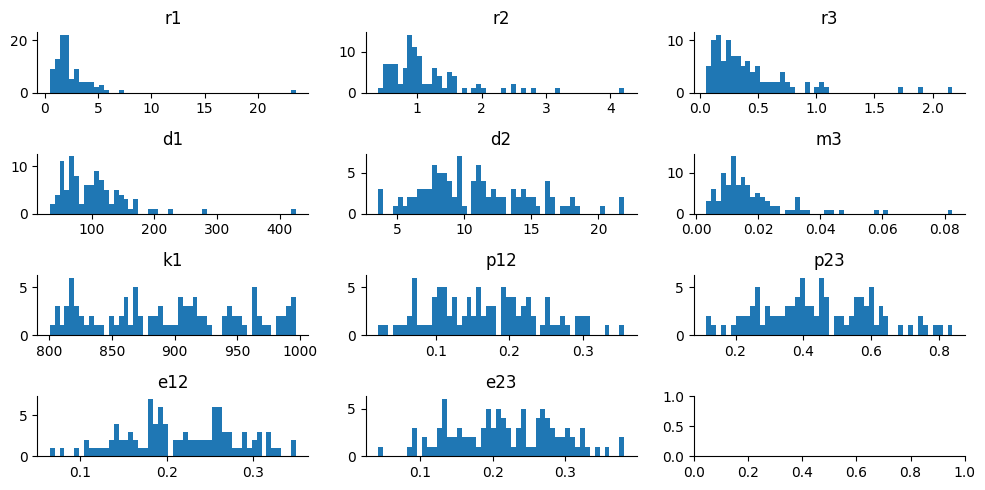

In [9]:
# model parameters and their prior distributions
loc_scale_for_prior = OrderedDict(
    r1=dict(loc=0.76, scale=0.59),
    r2=dict(loc=0.0, scale=0.42),
    r3=dict(loc=-1.3, scale=0.79),
    d1=dict(loc=4.61, scale=0.42),
    d2=dict(loc=2.30, scale=0.42),
    m3=dict(loc=-4.232, scale=0.6),
)


def sample_fishery_priors():
    sampled = {
        key: pyro.sample(key, dist.LogNormal(value["loc"], value["scale"]))
        for key, value in loc_scale_for_prior.items()
    }

    sampled["k1"] = pyro.sample("k1", dist.Uniform(800, 1000.0))
    sampled["p12"] = pyro.sample("p12", dist.Beta(3.0, 6.0)) / 2
    sampled["p23"] = pyro.sample("p23", dist.Beta(4.0, 5.0))
    sampled["e12"] = pyro.sample("e12", dist.Beta(5.0, 6.0)) / 2
    sampled["e23"] = pyro.sample("e23", dist.Beta(5.0, 6.0)) / 2

    return sampled


with pyro.plate("prior", num_samples):
    param_samples = sample_fishery_priors()


fig, ax = plt.subplots(4, 3, figsize=(10, 5))
ax = ax.flatten()

i = 0
for key, value in param_samples.items():
    ax[i].hist(value.detach().numpy(), bins=50)
    ax[i].set_title(key)
    i += 1

sns.despine()
fig.tight_layout()
fig.show()

In [10]:
param_sample_medians = {key: value.median() for key, value in param_samples.items()}
# medians are close to the ones reported in the paper


INITIAL_STATE_no_pressure = {
    "forage": torch.tensor(1000),
    "intermediate": torch.tensor(150),
    "apex": torch.tensor(30),
    "catch_intermediate": torch.tensor(0.0),
    "fishing_effort_forage": torch.tensor(0.0),
    "fishing_effort_intermediate": torch.tensor(0),
    "fishing_effort_apex": torch.tensor(0.0),
}


INITIAL_STATE_pressure = {
    "forage": torch.tensor(1000),
    "intermediate": torch.tensor(150),
    "apex": torch.tensor(30),
    "catch_intermediate": torch.tensor(0.0),
    "fishing_effort_forage": torch.tensor(0.0),
    "fishing_effort_intermediate": torch.tensor(0.7),
    "fishing_effort_apex": torch.tensor(0.07),
}


def add_postfix_to_dict(d, postfix):
    return {f"{k}_{postfix}": v for k, v in d.items()}


INITIAL_STATE_NO_PRESSURE = add_postfix_to_dict(
    INITIAL_STATE_no_pressure, "no_pressure"
)
INITIAL_STATE_PRESSURE = add_postfix_to_dict(INITIAL_STATE_pressure, "pressure")
INITIAL_STATE_DEPENDENT = add_postfix_to_dict(INITIAL_STATE_pressure, "dependent")
INITIAL_STATE_STATIC = add_postfix_to_dict(INITIAL_STATE_pressure, "static")

In [11]:
# the "postfix" buisiness is to handle running multiple models in parallel later on
# where we wan to keep track of different states for different scenarios
# in the trace


class FishDynamics(pyro.nn.PyroModule):
    def __init__(self, params: Dict = param_sample_medians, postfix: str = ""):
        super().__init__()
        self.params = params
        self.postfix = postfix

    @staticmethod
    def holling_tanner(
        B: torch.Tensor,
        r: torch.Tensor,
        K: torch.Tensor,
        M: torch.Tensor,
        F: torch.Tensor,
    ) -> torch.Tensor:
        """
        The general holling-tanner differential equation.
        This subtracts predator and fishing mortality from capacity-limited growth.
        B is the biomass for this trophic level.
        K is its carrying capacity, which may be a function of prey biomass.
        M is the mortality rate, potentially due to predation.
        F is the fishing mortality rate.
        """
        return r * B * (1 - B / K) - M * B - F * B

    @staticmethod
    def mortality_from_predation(
        B: torch.Tensor, B_pred: torch.Tensor, p: torch.Tensor, D: torch.Tensor
    ) -> torch.Tensor:
        """
        Mortality rate of prey due to predation.
        This plugs in as M above for prey species with biomass B.
        p is the maximum rate of predation.
        B is the biomass of the prey, and B_pred is the biomass of the predator.
        D is the biomass when the predation rate reaches half of its maximum.
        """
        return (p * B_pred) / (D + B)

    @staticmethod
    def carrying_capacity_of_predator(
        B_prey: torch.Tensor, e: torch.Tensor
    ) -> torch.Tensor:
        """
        Carrying capacity of the predator — this plugs in as K above for predator species.
        e is the proportion of prey biomass that is converted into predator biomass.
        """
        return B_prey * e

    @staticmethod
    def intermediate_trophic_level(
        B: torch.Tensor,
        r: torch.Tensor,
        B_prey: torch.Tensor,
        e: torch.Tensor,
        B_pred: torch.Tensor,
        p: torch.Tensor,
        D: torch.Tensor,
        F: torch.Tensor,
    ) -> torch.Tensor:
        """
        Equation for intermediate trophic levels that are both prey and predator.
        """
        K = FishDynamics.carrying_capacity_of_predator(B_prey, e)
        M = FishDynamics.mortality_from_predation(B, B_pred, p, D)
        return FishDynamics.holling_tanner(B, r, K, M, F)

    @staticmethod
    def apex_trophic_level(
        B: torch.Tensor,
        r: torch.Tensor,
        B_prey: torch.Tensor,
        e: torch.Tensor,
        M: torch.Tensor,
        F: torch.Tensor,
    ) -> torch.Tensor:
        """
        The top trophic level that has some constant natural mortality rate.
        """

        K = FishDynamics.carrying_capacity_of_predator(B_prey, e)

        return FishDynamics.holling_tanner(B, r, K, M, F)

    @staticmethod
    def forage_trophic_level(
        B: torch.Tensor,
        r: torch.Tensor,
        K: torch.Tensor,
        B_pred: torch.Tensor,
        p: torch.Tensor,
        D: torch.Tensor,
        F: torch.Tensor,
    ) -> torch.Tensor:
        """
        The bottom trophic level that has some constant carrying capacity
        """

        M = FishDynamics.mortality_from_predation(B, B_pred, p, D)
        return FishDynamics.holling_tanner(B, r, K, M, F)

    def forward(self, X: State[torch.Tensor]) -> State[torch.Tensor]:
        r1, r2, r3, d1, d2, m3, k1, p12, p23, e12, e23 = self.params.values()
        postfix = self.postfix

        dX = dict()
        dX[f"forage_{postfix}"] = FishDynamics.forage_trophic_level(
            X[f"forage_{postfix}"],
            r1,
            k1,
            X[f"intermediate_{postfix}"],
            p12,
            d1,
            X[f"fishing_effort_forage_{postfix}"],
        )

        dX[f"intermediate_{postfix}"] = FishDynamics.intermediate_trophic_level(
            B=X[f"intermediate_{postfix}"],
            r=r2,
            B_prey=X[f"forage_{postfix}"],
            e=e12,
            B_pred=X[f"apex_{postfix}"],
            p=p23,
            D=d2,
            F=X[f"fishing_effort_intermediate_{postfix}"],
        )

        dX[f"apex_{postfix}"] = FishDynamics.apex_trophic_level(
            B=X[f"apex_{postfix}"],
            r=r3,
            B_prey=X[f"intermediate_{postfix}"],
            e=e23,
            M=m3,
            F=X[f"fishing_effort_apex_{postfix}"],
        )

        dX[f"catch_intermediate_{postfix}"] = (
            X[f"fishing_effort_intermediate_{postfix}"] * X[f"intermediate_{postfix}"]
        )

        dX[f"fishing_effort_forage_{postfix}"] = torch.zeros_like(
            X[f"fishing_effort_forage_{postfix}"]
        )
        dX[f"fishing_effort_intermediate_{postfix}"] = torch.zeros_like(
            X[f"fishing_effort_intermediate_{postfix}"]
        )
        dX[f"fishing_effort_apex_{postfix}"] = torch.zeros_like(
            X[f"fishing_effort_apex_{postfix}"]
        )

        return dX

### - [Trajectories under full fishing/no fishing regimes](#trajectories-under-full-fishingno-fishing-regimes)


To get some intuitions into how the sytem works, we can inspect its behavior under a couple of different fishing regimes. We start with running the system for ten years without any interventions to obtain meaningful close-to-equilibrium states for our experiment further on.

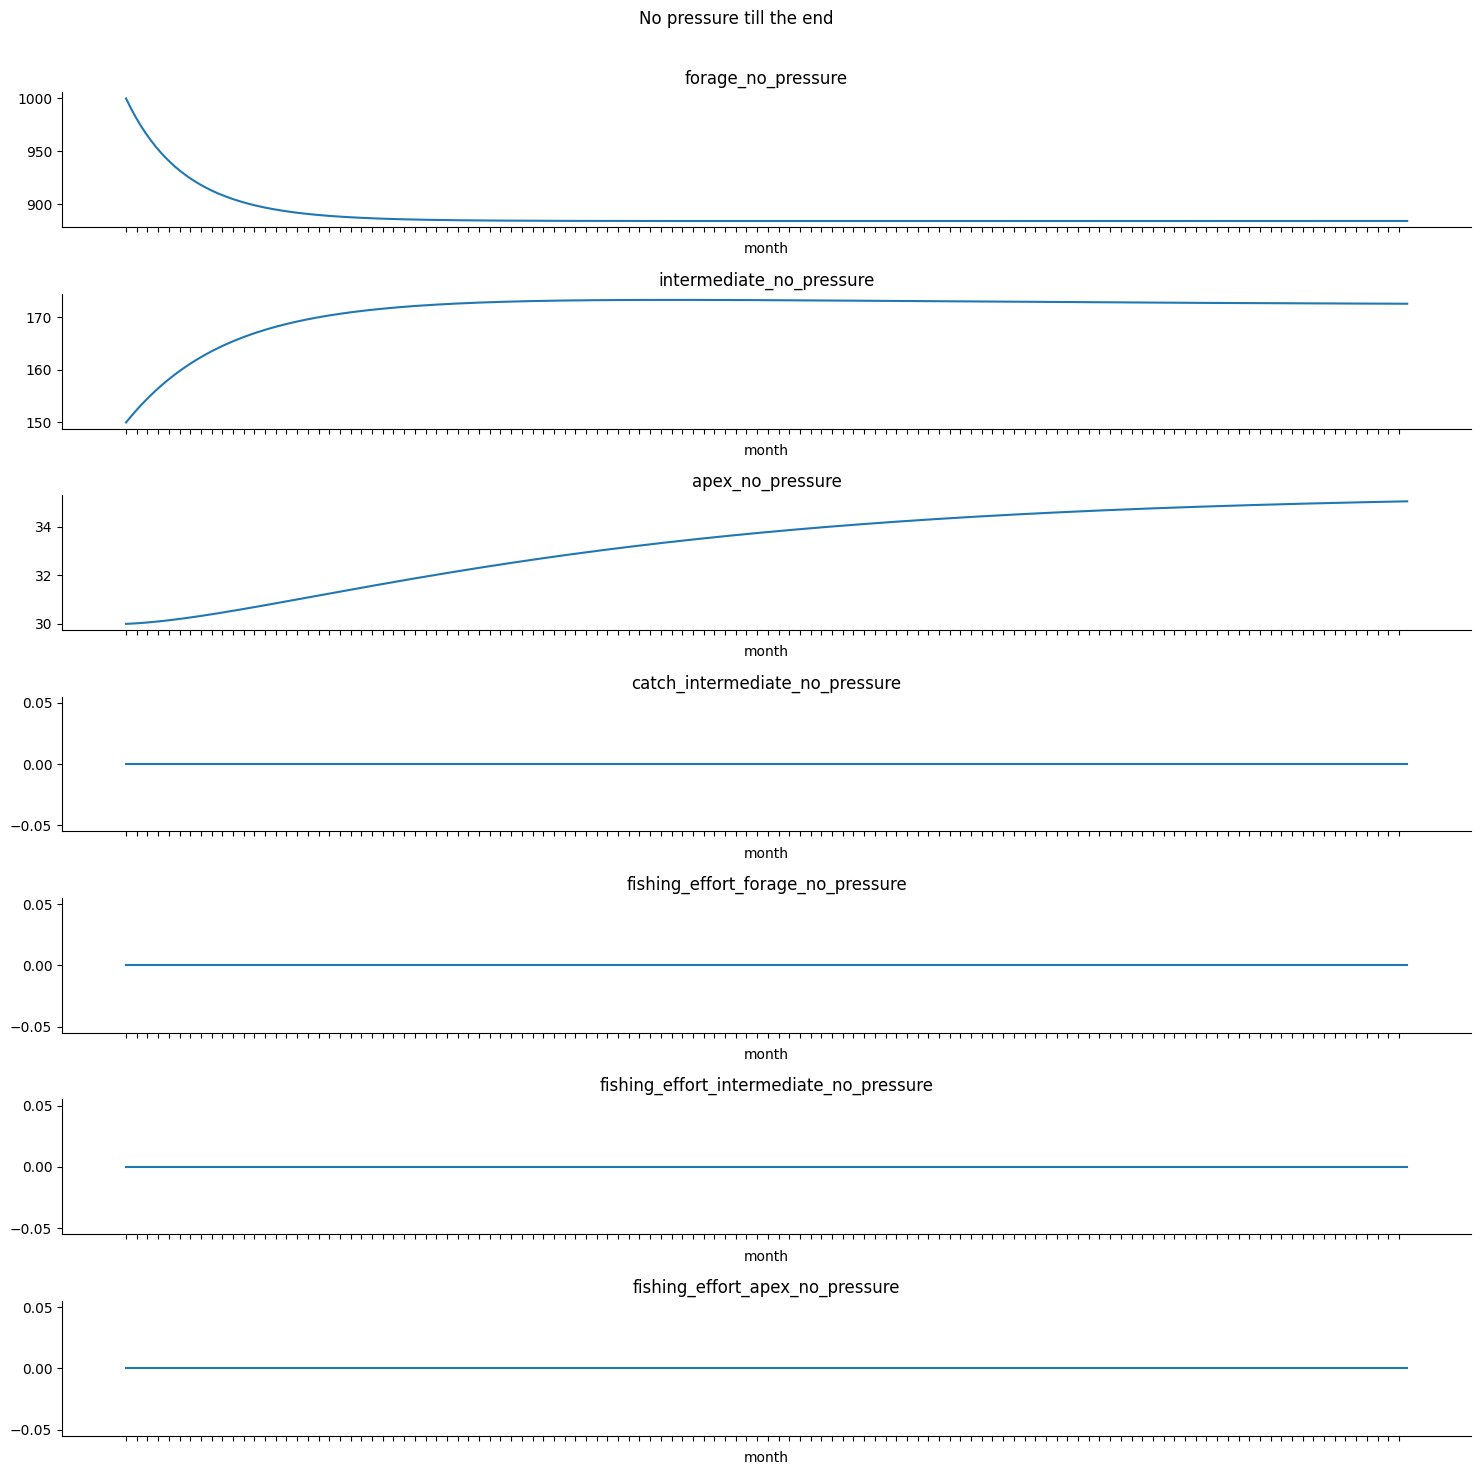

In [12]:
fish_dynamics_pressure = FishDynamics(postfix="pressure")
fish_dynamics_no_pressure = FishDynamics(postfix="no_pressure")


with TorchDiffEq(), LogTrajectory(end_of_the_world_logging_times) as lt_end:
    simulate(
        fish_dynamics_no_pressure,
        INITIAL_STATE_NO_PRESSURE,
        start_time,
        end_of_the_world,
    )

trajectory_end = lt_end.trajectory

plot_trajectories_no_uncertainty(
    trajectory_end, "No pressure till the end", end_of_the_world_logging_times
)

In [13]:
trajectory_end.keys()

stable_initial_biomass = {
    "forage": trajectory_end["forage_no_pressure"][-1],
    "intermediate": trajectory_end["intermediate_no_pressure"][-1],
    "apex": trajectory_end["apex_no_pressure"][-1],
}

print(stable_initial_biomass)

{'forage': tensor(883.9730), 'intermediate': tensor(172.5383), 'apex': tensor(35.0420)}


In [14]:
def update_init_with_equilibrium(init: Dict):
    for key_stable in stable_initial_biomass:
        for key in init.keys():
            if key.startswith(key_stable):
                init[key] = stable_initial_biomass[key_stable]

    return init


# update to median-based 10 year near-equilibrium biomass states
INITIAL_STATE_NO_PRESSURE = update_init_with_equilibrium(INITIAL_STATE_NO_PRESSURE)
INITIAL_STATE_PRESSURE = update_init_with_equilibrium(INITIAL_STATE_PRESSURE)
INITIAL_STATE_DEPENDENT = update_init_with_equilibrium(INITIAL_STATE_DEPENDENT)
INITIAL_STATE_STATIC = update_init_with_equilibrium(INITIAL_STATE_STATIC)

Now we switch to running one year only. For now, no uncertainty trajectories using the parameter medians and two different fishing pressure levels, without intervening on the fishing pressure during the season.

In [15]:
with TorchDiffEq(), LogTrajectory(logging_times) as lt_no_pressure:
    simulate(
        fish_dynamics_no_pressure,
        INITIAL_STATE_NO_PRESSURE,
        start_time,
        end_time,
    )

trajectory_no_pressure = lt_no_pressure.trajectory

In [16]:
with TorchDiffEq(), LogTrajectory(logging_times) as lt_pressure:
    simulate(fish_dynamics_pressure, INITIAL_STATE_PRESSURE, start_time, end_time)

trajectory_pressure = lt_pressure.trajectory

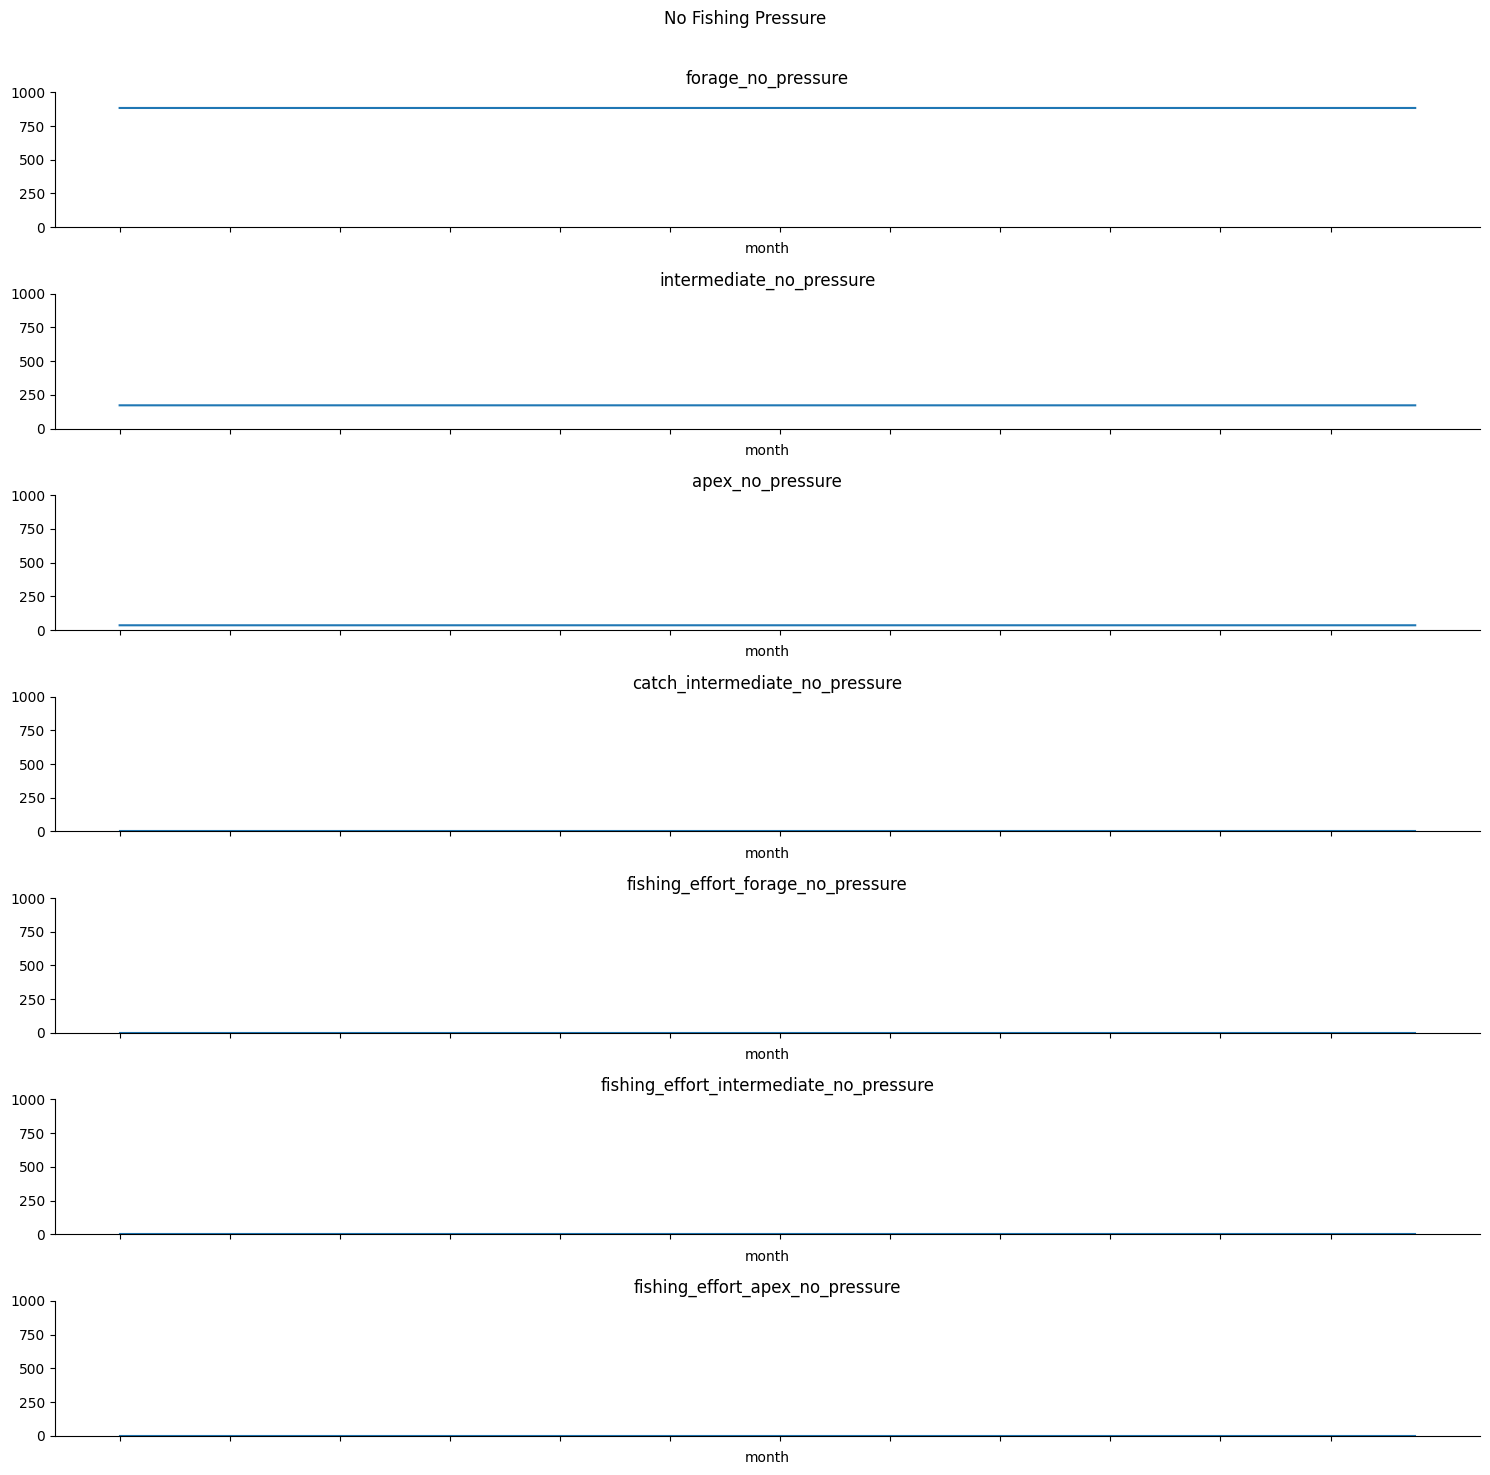

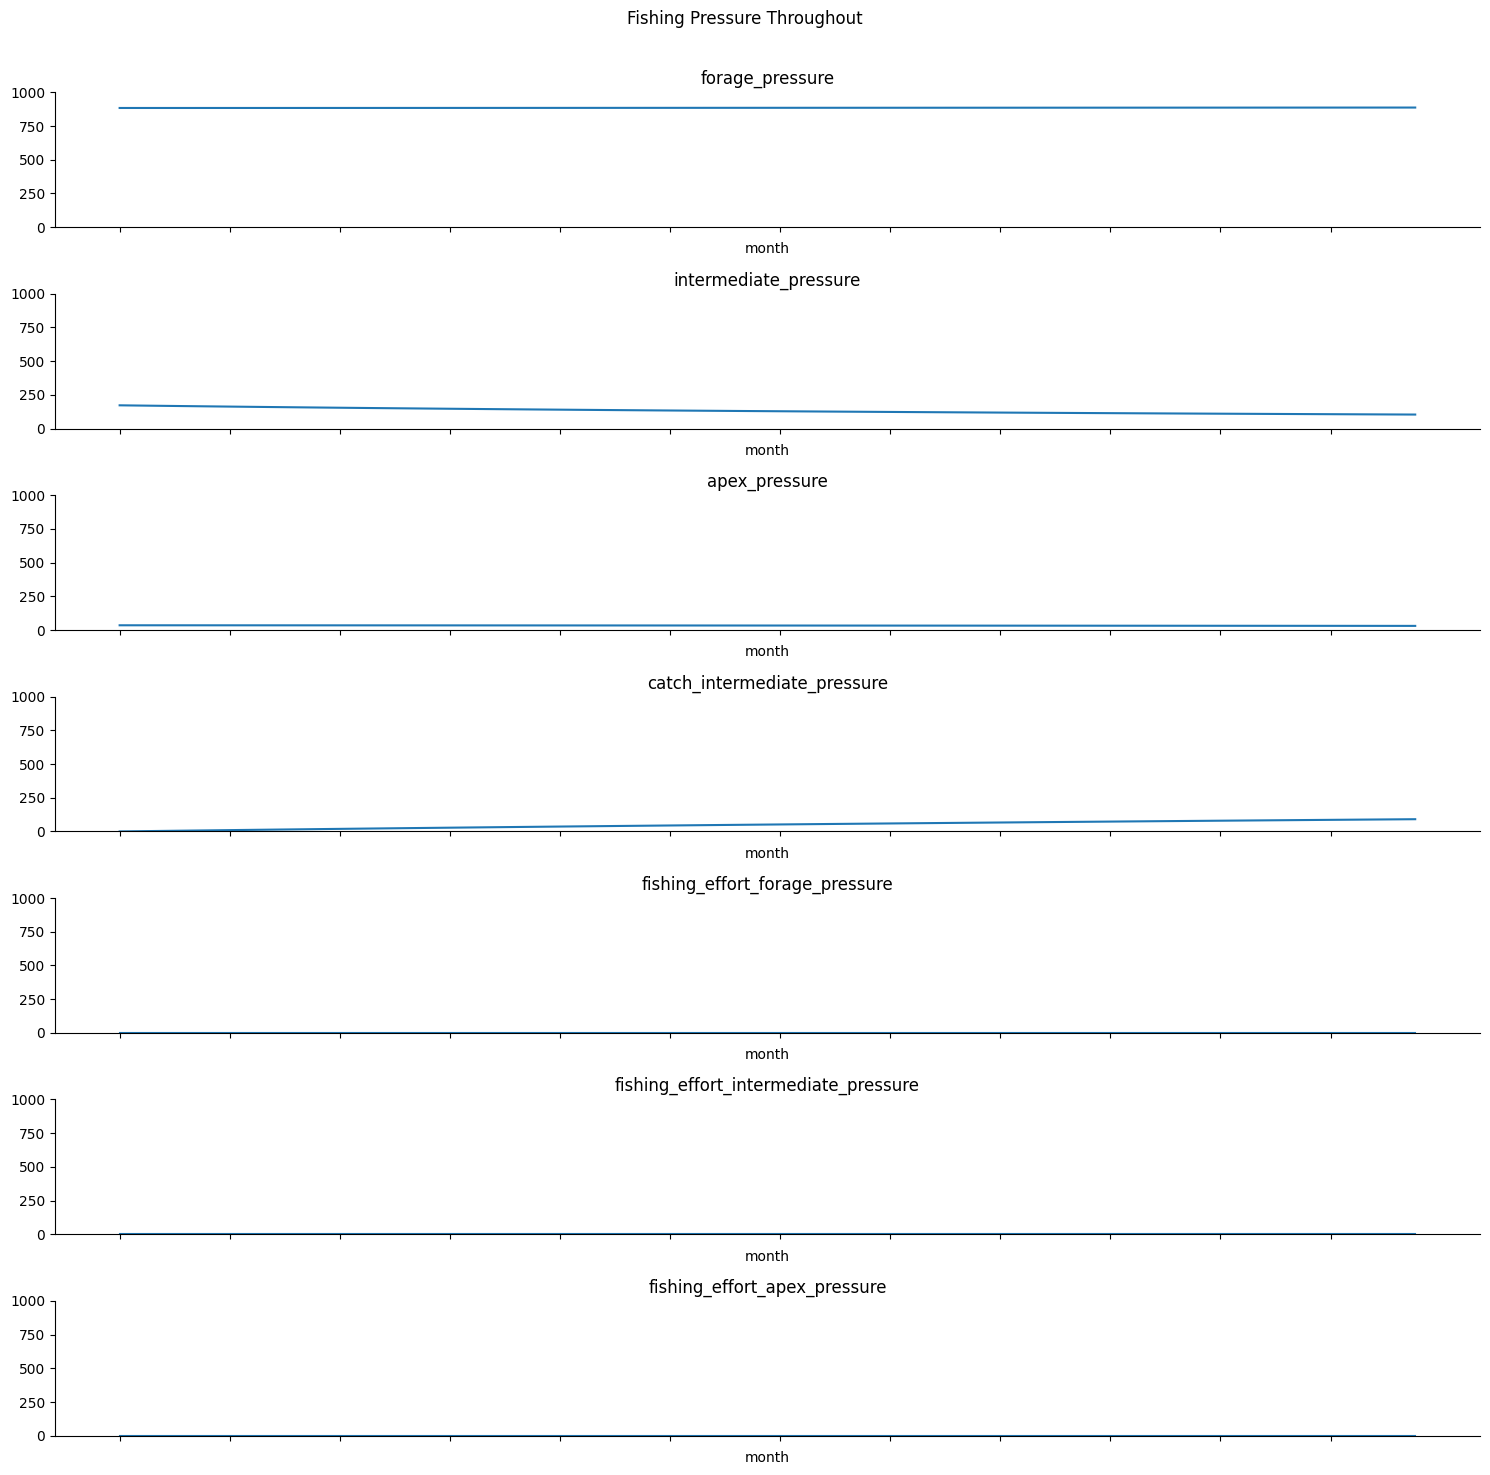

In [17]:
plot_trajectories_no_uncertainty(
    trajectory_no_pressure,
    "No Fishing Pressure",
    logging_times=logging_times,
    ylim=(0, 1000),
)
plot_trajectories_no_uncertainty(
    trajectory_pressure,
    "Fishing Pressure Throughout",
    logging_times=logging_times,
    ylim=(0, 1000),
)

### - [Incorporate interventions and uncertainty about model parameters](#incorporate-interventions-and-uncertainty-about-model-parameters)


Here, we first define the intervention needed, and add uncertainty to parameters. Then we simulate in parallel in the following regimes: (1) no fishing pressure, (2) fishing pressure with no season shutdown, (3) dynamic season shutdowns with quota in `range(0, 121, 5)`.

In [18]:
# this function will be used to trigger the fishing pressure intervention
def stop_fishing_policy(target_state: State[torch.tensor], postfix: str = "dependent"):
    """
    The event function for the stop fishing policy. This is a function
    that passes zero when the catch of the intermediate fish passes a quota
    specified by `target_state`.
    """

    def event_f(t: torch.tensor, state: State[torch.tensor]):
        return (
            state[f"catch_intermediate_{postfix}"]
            - target_state[f"catch_intermediate_{postfix}"]
        )

    return event_f

In [19]:
# an example of a quota
quota = {"catch_intermediate_dependent": torch.tensor(40.0)}

# definition of the fishing pressure intervention
# effectively sets it to zero when the event function is triggered
season_ends = {
    key: torch.tensor(0.0)
    for key in INITIAL_STATE_DEPENDENT.keys()
    if key.startswith("fishing_effort")
}

In [20]:
# add uncertainty about initial state
def randomize_init_state(init: Dict, postfix=""):
    init = init.copy()

    if postfix != "":
        postfix = "_" + postfix
    for key, value in init.items():

        if key.startswith("forage"):
            init[key] = pyro.sample(
                f"forage_init{postfix}",
                dist.Uniform(0.95 * init[key], 1.05 * init[key]),
            )
        elif key.startswith("intermediate"):
            init[key] = pyro.sample(
                f"intermediate_init{postfix}",
                dist.Uniform(0.95 * init[key], 1.05 * init[key]),
            )
        elif key.startswith("apex"):
            init[key] = pyro.sample(
                f"apex_init{postfix}", dist.Uniform(0.95 * init[key], 1.05 * init[key])
            )

    for key, value in init.items():
        if key.startswith("fishing_effort_intermediate") and init[key] != 0:
            init[key] = pyro.sample(
                f"fishing_effort_intermediate{postfix}",
                dist.Normal(init[key], init[key] * 0.1),
            ).clamp(0.001, 0.999)
        elif key.startswith("fishing_effort_apex") and init[key] != 0:
            init[key] = pyro.sample(
                f"fishing_effort_apex{postfix}", dist.Normal(init[key], init[key] * 0.1)
            ).clamp(0.001, 0.999)

    return init


# helper to coordinate init state values across different scenarios
def copy_init_state_values(source: Dict, target, postfix: str, copy_pressure=False):
    init = target.copy()
    for key in source.keys():
        if key.startswith("forage"):
            init[f"forage_{postfix}"] = source[key]
        elif key.startswith("intermediate"):
            init[f"intermediate_{postfix}"] = source[key]
        elif key.startswith("apex"):
            init[f"apex_{postfix}"] = source[key]

    if copy_pressure:
        for key in source.keys():
            if key.startswith("fishing_effort_intermediate"):
                init[f"fishing_effort_intermediate_{postfix}"] = source[key]
            elif key.startswith("fishing_effort_apex"):
                init[f"fishing_effort_apex_{postfix}"] = source[key]

    return init

In [21]:
pyro.clear_param_store()
torch.manual_seed(42)
pyro.set_rng_seed(42)
quota_list = [float(x) for x in range(0, 121, 5)]


def bayesian_parallel_dynamics():

    # sample noise to be used throughout
    shared_noise = sample_fishery_priors()

    # the initial state biomass noise is also shared; we sample once and then copy over
    INITIAL_STATE_DEPENDENT_sample = randomize_init_state(
        INITIAL_STATE_DEPENDENT, "dependent"
    )

    INITIAL_STATE_NO_PRESSURE_sample = copy_init_state_values(
        source=INITIAL_STATE_DEPENDENT_sample,
        target=INITIAL_STATE_NO_PRESSURE,
        postfix="no_pressure",
    )

    INITIAL_STATE_PRESSURE_sample = copy_init_state_values(
        source=INITIAL_STATE_DEPENDENT_sample,
        target=INITIAL_STATE_PRESSURE,
        postfix="pressure",
        copy_pressure=True,
    )

    fish_dynamics_no_pressure = FishDynamics(
        params=shared_noise, postfix="no_pressure"
    )
    fish_dynamics_pressure = FishDynamics(params=shared_noise, postfix="pressure")
    fish_dynamics_state_dependent = FishDynamics(
        params=shared_noise, postfix="dependent"
    )

    # no fishing pressure
    with TorchDiffEq(), LogTrajectory(logging_times, is_traced=True):
        simulate(
            fish_dynamics_no_pressure,
            INITIAL_STATE_NO_PRESSURE_sample,
            start_time,
            end_time,
        )

    # fishing pressure, no season shutdown
    with TorchDiffEq(), LogTrajectory(logging_times, is_traced=True):
        simulate(
            fish_dynamics_pressure,
            INITIAL_STATE_PRESSURE_sample,
            start_time,
            end_time,
        )

    # generate samples for a range of triggering quota settings
    for quota_limit in [torch.tensor(k) for k in quota_list]:

        quota = {"catch_intermediate_dependent": quota_limit}
        with TorchDiffEq(), LogTrajectoryPostfix(
            logging_times, is_traced=True, postfix=str(quota_limit.item())
        ):
            with DynamicIntervention(
                event_fn=stop_fishing_policy(quota), intervention=season_ends
            ):
                simulate(
                    fish_dynamics_state_dependent,
                    INITIAL_STATE_DEPENDENT_sample,
                    start_time,
                    logging_times[-1],
                )

fishery_predictive = Predictive(
    bayesian_parallel_dynamics,
    num_samples=num_samples,
)
fishery_samples = fishery_predictive()

In [22]:
# cleanup samples
pressure_samples = {
    key: value
    for key, value in fishery_samples.items()
    if "pressure" in key and "no" not in key
}
no_pressure_samples = {
    key: value for key, value in fishery_samples.items() if "no_pressure" in key
}
dependent_supersamples = {
    key: value for key, value in fishery_samples.items() if "dependent" in key
}

dependent_samples = {}
for q in quota_list:
    dependent_samples[q] = {
        key: value for key, value in dependent_supersamples.items() if str(q) in key
    }
    dependent_samples[q].update(
        {
            key: value
            for key, value in dependent_supersamples.items()
            if "init_dependent" in key
        }
    )

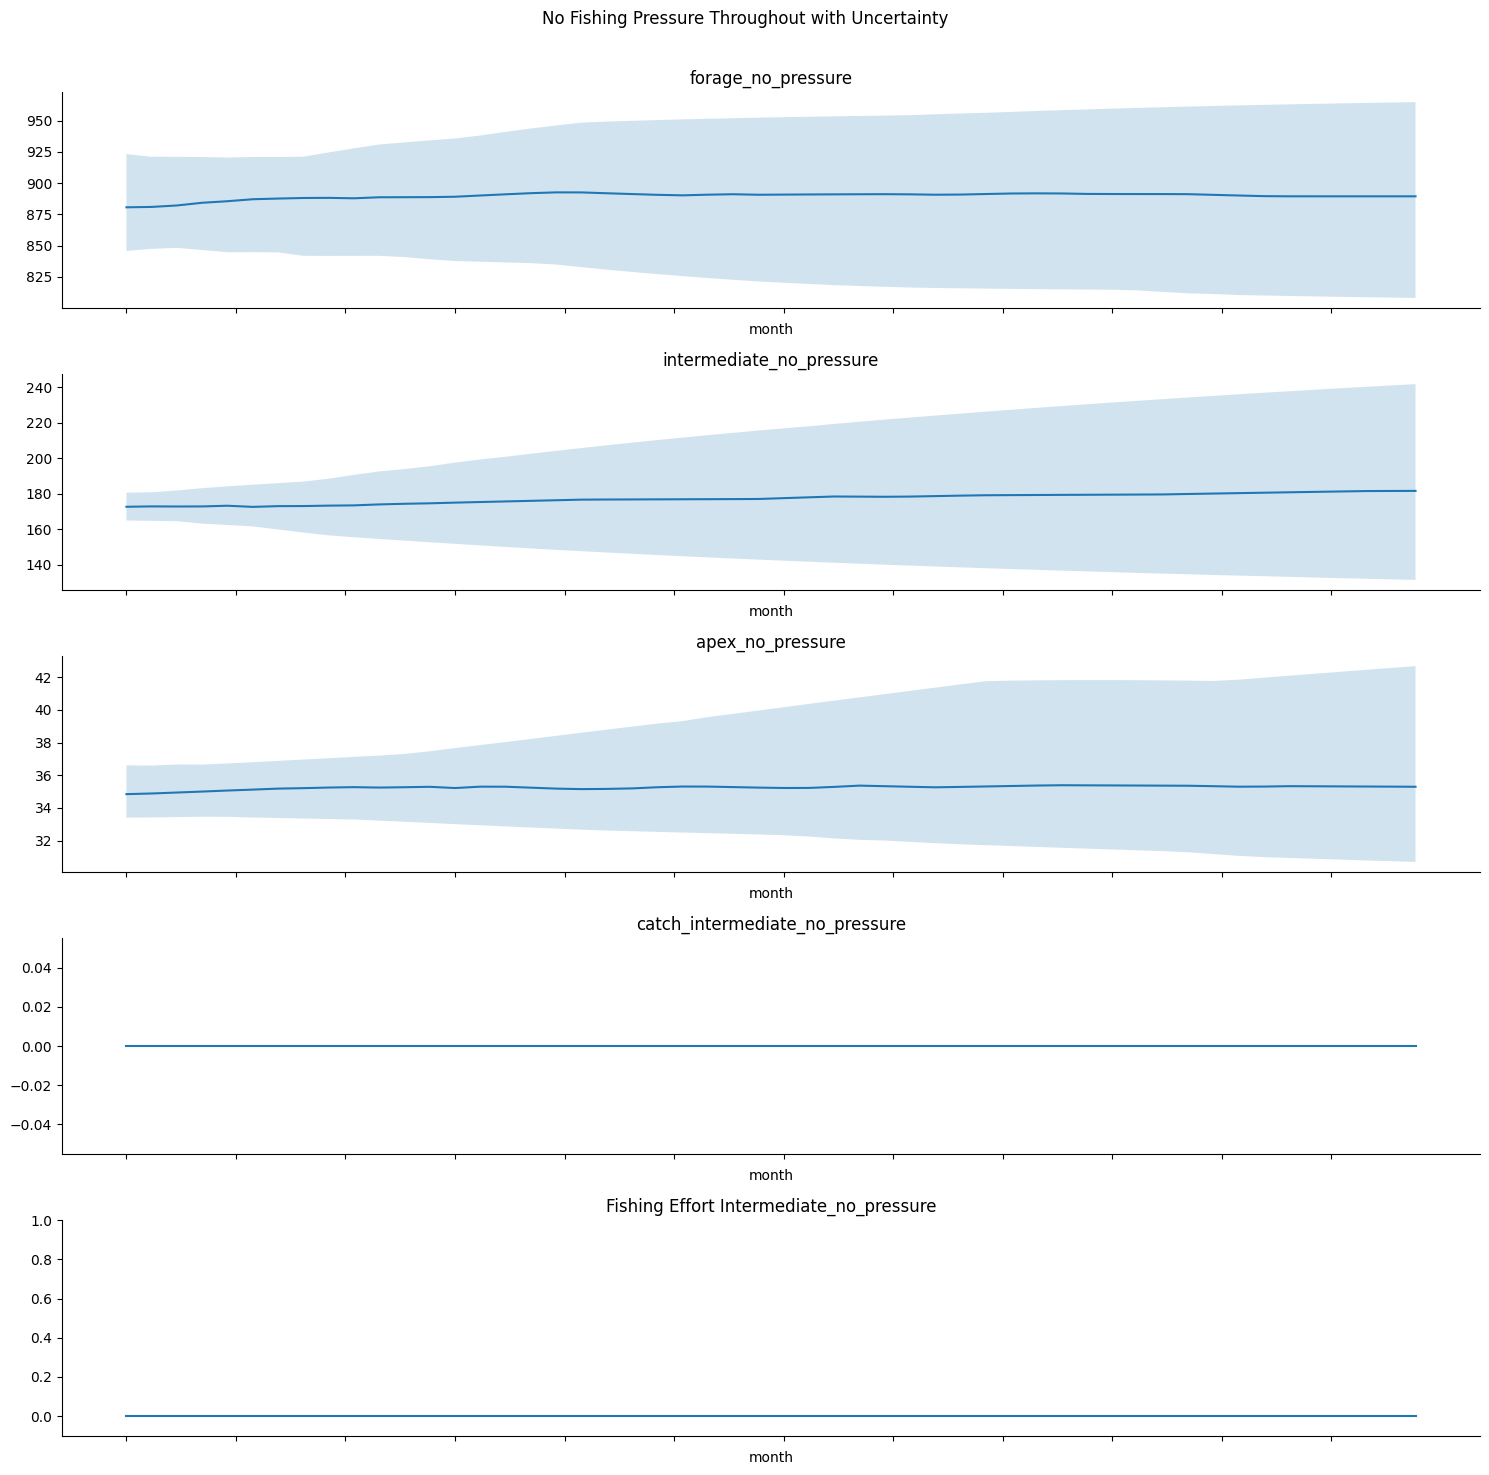

In [23]:
plot_no_pressure, ax_no_pressure = plot_trajectory_samples(
    no_pressure_samples,
    postfix="no_pressure",
    title="No Fishing Pressure Throughout with Uncertainty",
)

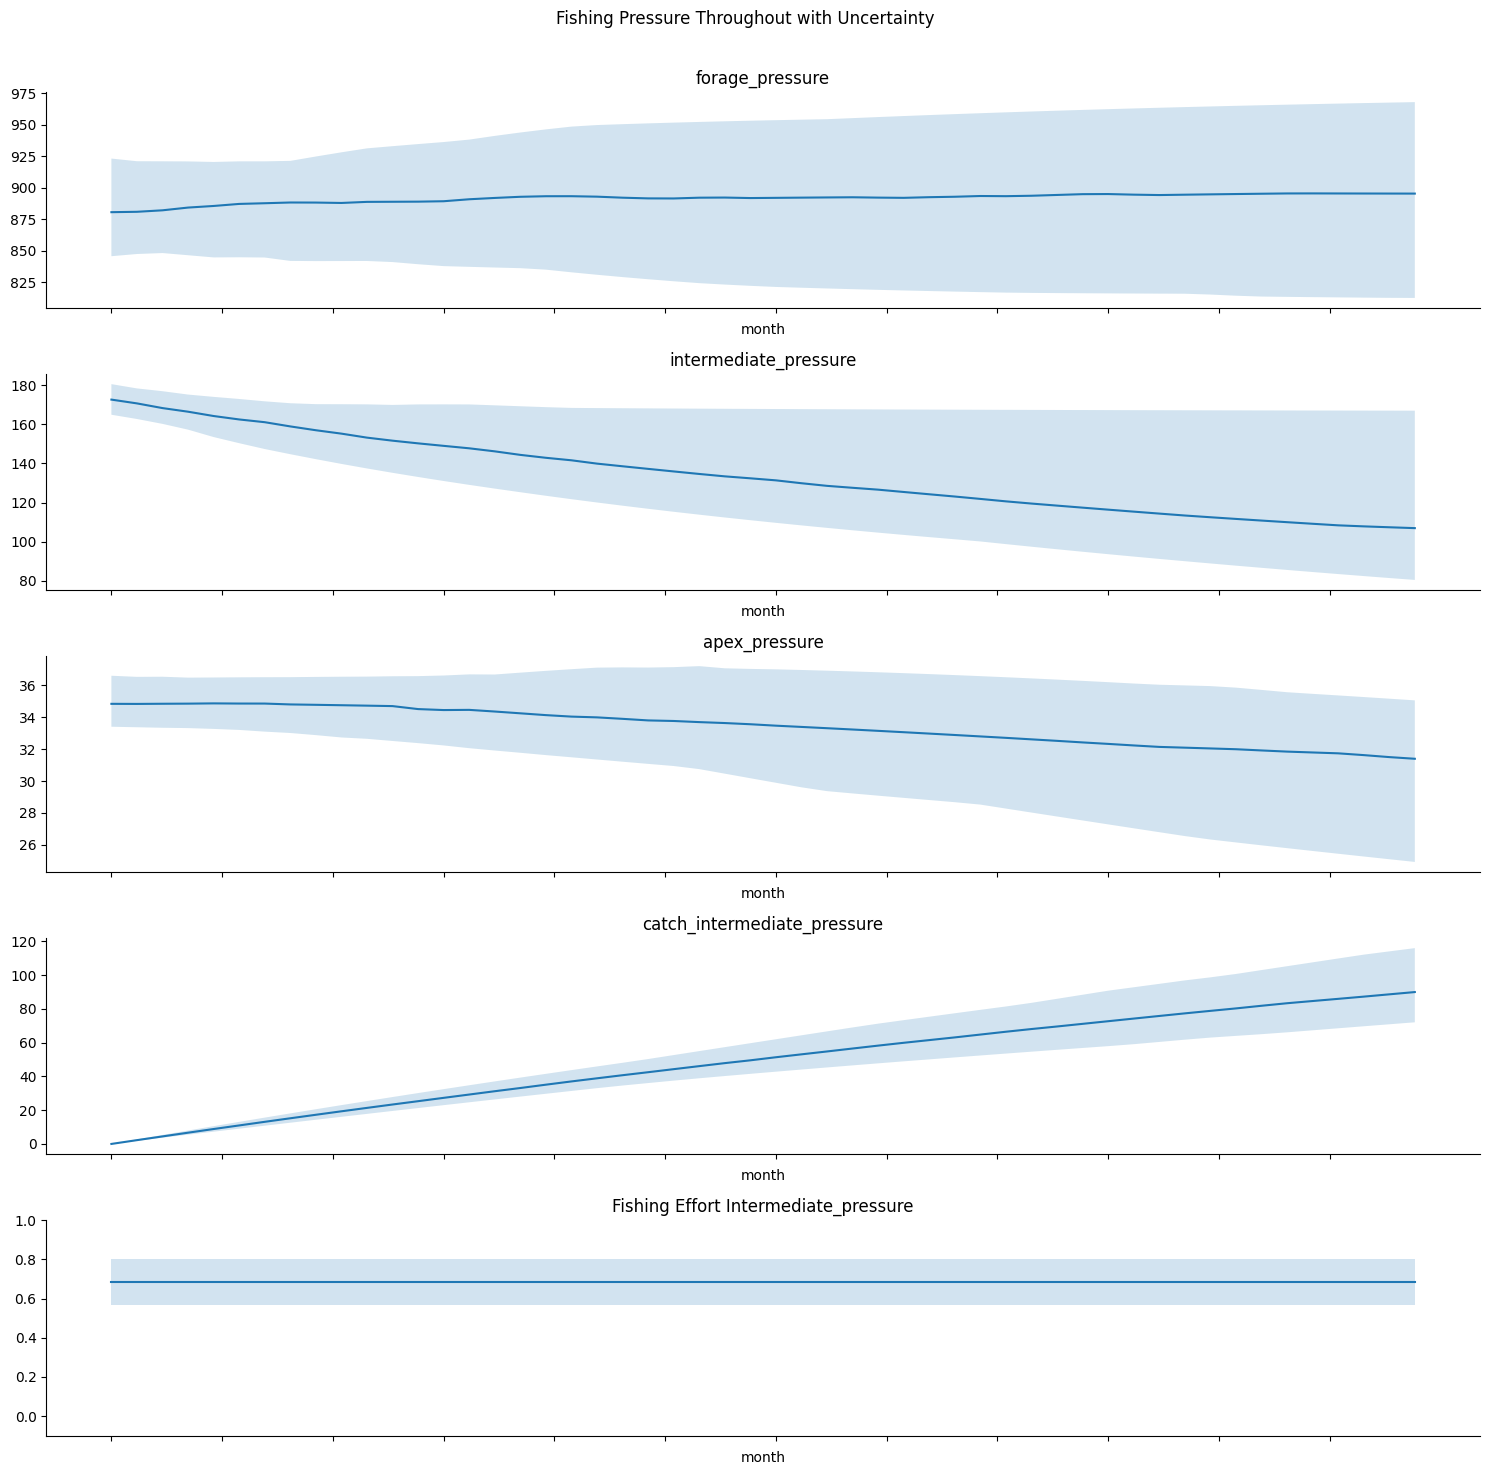

In [24]:
plot_pressure, ax_pressure = plot_trajectory_samples(
    pressure_samples,
    postfix="pressure",
    title="Fishing Pressure Throughout with Uncertainty",
)

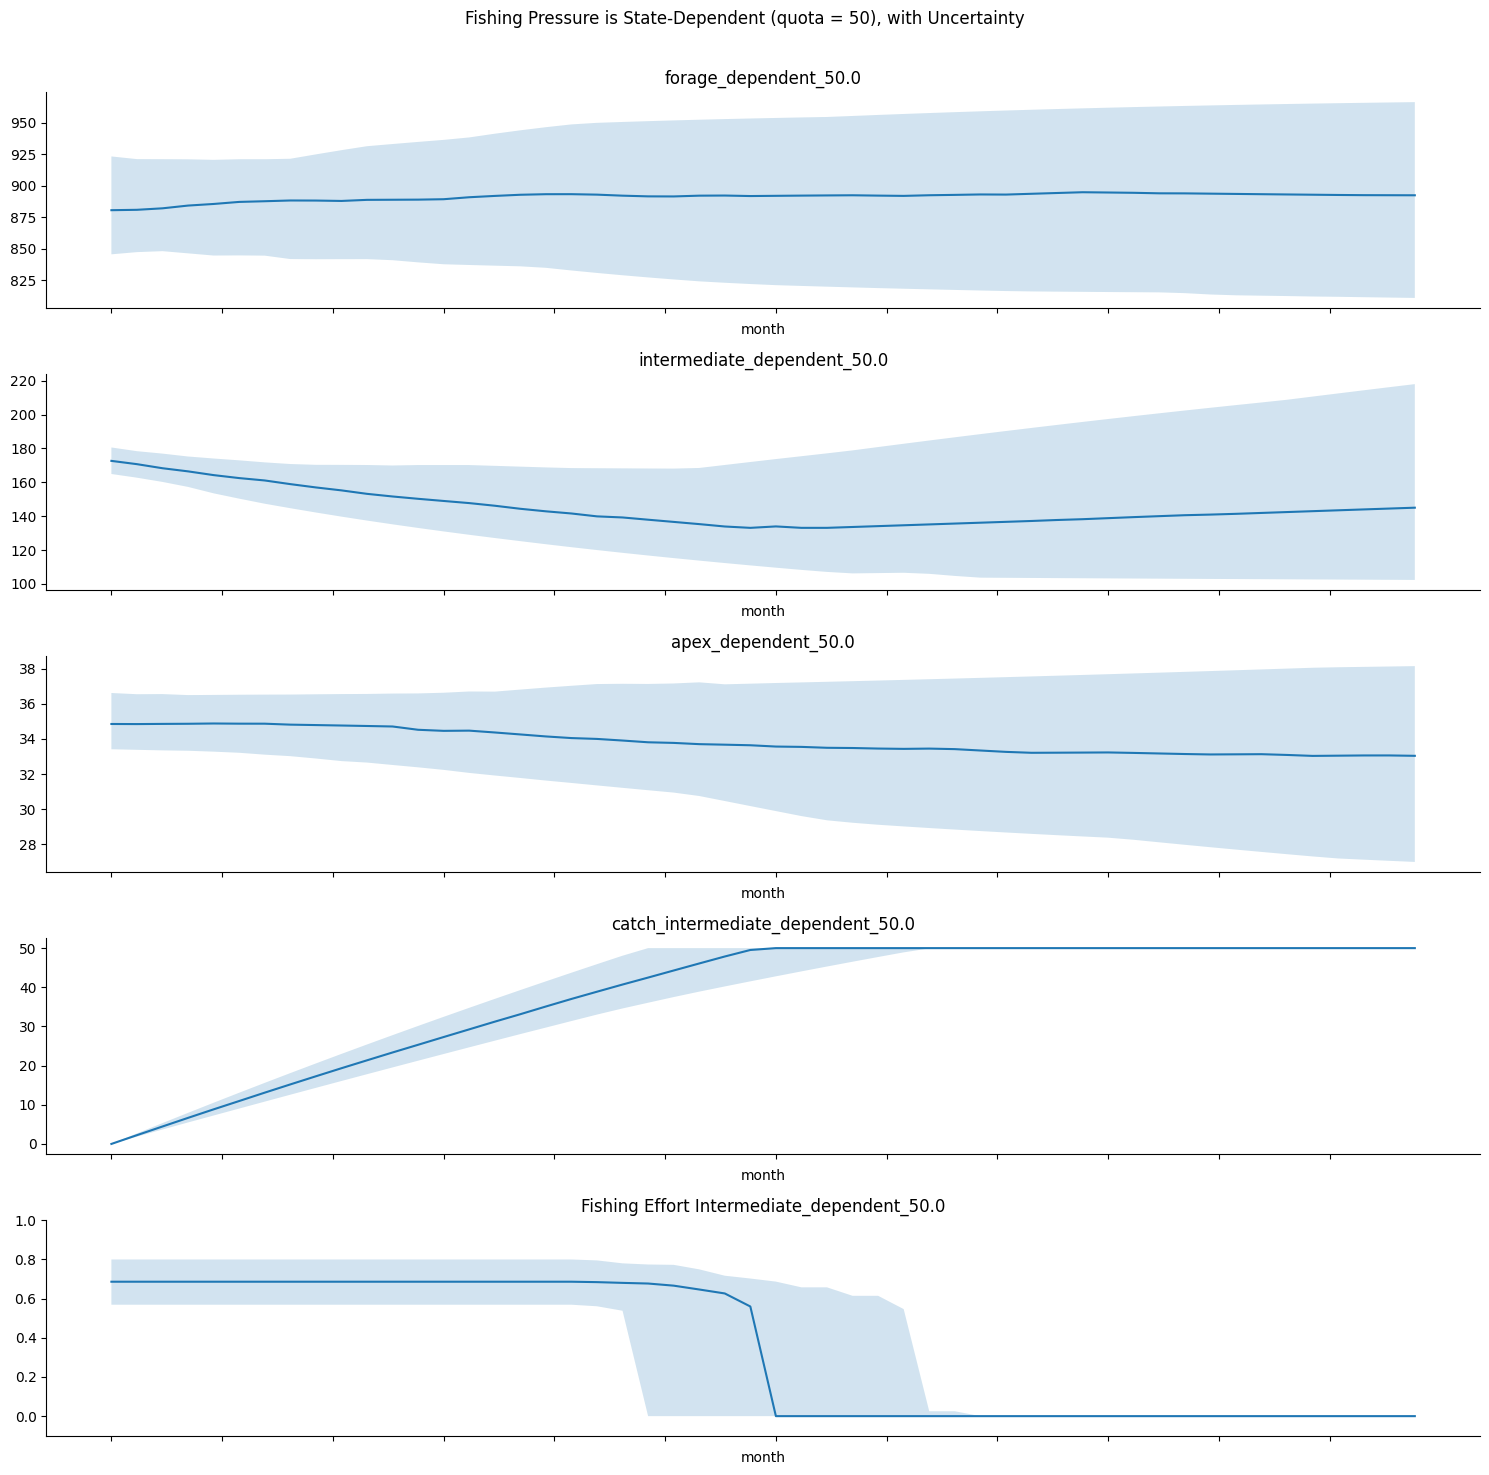

In [25]:
plot_dependent, ax_dependent = plot_trajectory_samples(
    dependent_samples[50.0],
    postfix="dependent_50.0",
    title="Fishing Pressure is State-Dependent (quota = 50), with Uncertainty",
)

12 12


/tmp/ipykernel_97163/3203047983.py:108: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  joint_fig.show()


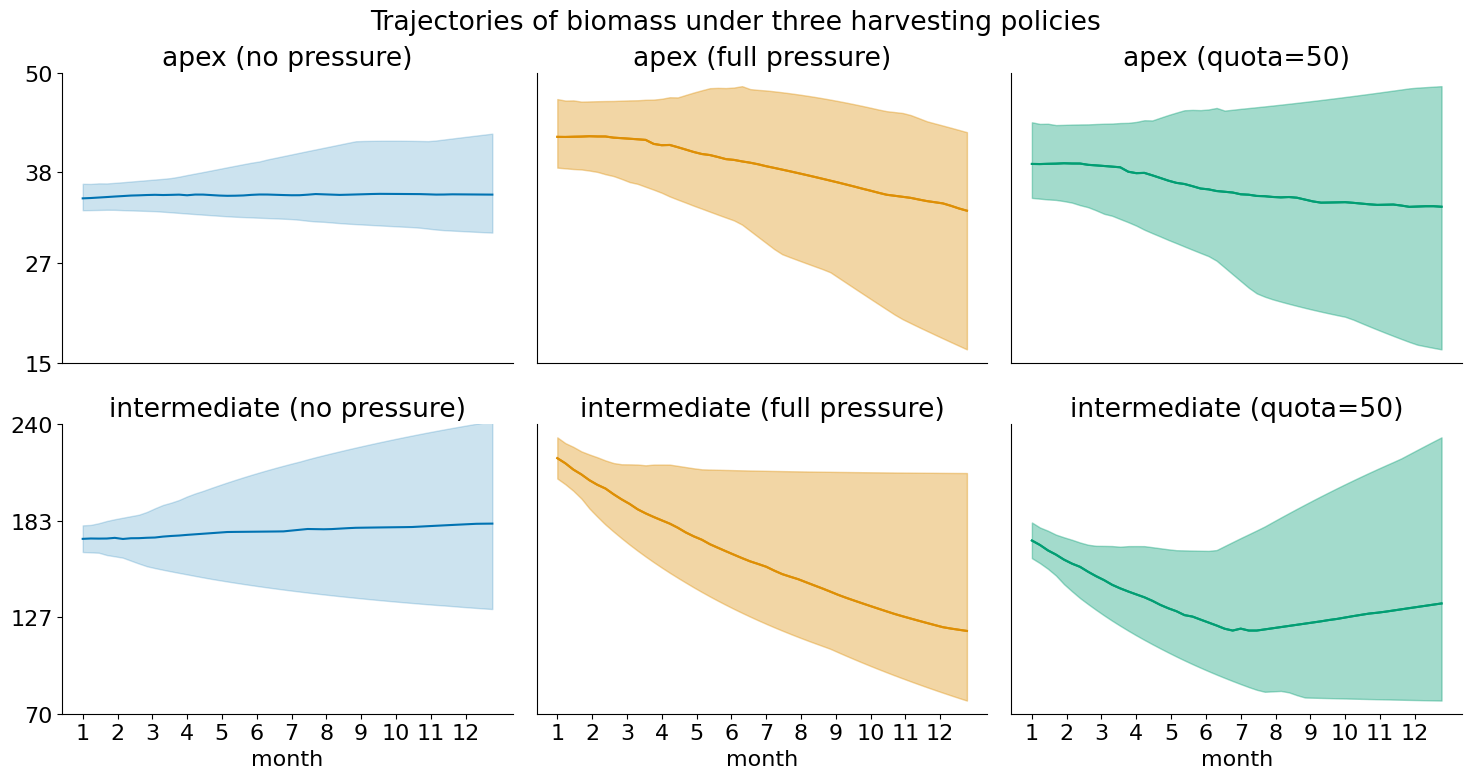

In [26]:
# Paper figure with trajectories in three scenarios

no_pressure_samples_medians, no_pressure_samples_lows, no_pressure_samples_highs = (
    summarize_states(no_pressure_samples)
)
pressure_samples_medians, pressure_samples_lows, pressure_samples_highs = (
    summarize_states(pressure_samples)
)
dependend_50_samples_medians, dependend_50_samples_lows, dependend_50_samples_highs = (
    summarize_states(dependent_samples[50.0])
)

x_ticks = torch.arange(logging_times.min(), logging_times.max(), 1 / 12)
x_labels = range(1, 13)

print(len(x_ticks), len(x_labels))
key_cores = [
    "apex",
    "intermediate",
]

ylim = [(15, 50), (70, 240)]


plt.rcParams.update({"font.size": 16})

colors = sns.color_palette("colorblind", n_colors=len(key_cores) * 3)

joint_fig, joint_ax = plt.subplots(2, 3, figsize=(15, 8))


for i, key in enumerate(key_cores):
    joint_ax[i, 0].plot(
        logging_times,
        no_pressure_samples_medians[f"{key}_no_pressure"],
        label=f"{key}_no_pressure",
        color=colors[0],
    )

    joint_ax[i, 0].set_title(f"{key} (no pressure)")
    joint_ax[i, 0].fill_between(
        logging_times,
        no_pressure_samples_lows[f"{key}_no_pressure"],
        no_pressure_samples_highs[f"{key}_no_pressure"],
        alpha=0.2,
        color=colors[0],
    )

    joint_ax[i, 0].set_ylim(ylim[i])
    yticks = np.linspace(*ylim[i], 4).round(0)
    joint_ax[i, 0].set_yticks(yticks)

    for i, key in enumerate(key_cores):

        joint_ax[i, 1].plot(
            logging_times,
            pressure_samples_medians[f"{key}_pressure"],
            label=f"{key}_pressure",
            color=colors[1],
        )
        joint_ax[i, 1].set_title(f"{key} (full pressure)")
        joint_ax[i, 1].fill_between(
            logging_times,
            pressure_samples_lows[f"{key}_pressure"],
            pressure_samples_highs[f"{key}_pressure"],
            alpha=0.2,
            color=colors[1],
        )

        joint_ax[i, 2].plot(
            logging_times,
            dependend_50_samples_medians[f"{key}_dependent_50.0"],
            label=f"{key}_dependent_50.0",
            color=colors[2],
        )
        joint_ax[i, 2].set_title(f"{key} (quota=50)")
        joint_ax[i, 2].fill_between(
            logging_times,
            dependend_50_samples_lows[f"{key}_dependent_50.0"],
            dependend_50_samples_highs[f"{key}_dependent_50.0"],
            alpha=0.2,
            color=colors[2],
        )


for i in range(2):
    for m in (1, 2):
        joint_ax[i, m].tick_params(axis="y", left=False, labelleft=False)


for i in range(3):
    joint_ax[0, i].set_xticks([])
    joint_ax[0, i].set_xticklabels([])

    joint_ax[1, i].set_xticks(x_ticks)
    joint_ax[1, i].set_xticklabels(x_labels)
    joint_ax[1, i].set_xlabel("month")


joint_fig.tight_layout()

sns.despine()

joint_fig.suptitle(
    "Trajectories of biomass under three harvesting policies",
)
joint_fig.subplots_adjust(top=0.9)
joint_fig.show()

joint_fig.savefig("figures/fishery_trajectories.pdf", dpi=300)

/tmp/ipykernel_97163/2922191222.py:89: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  catch_fig.show()


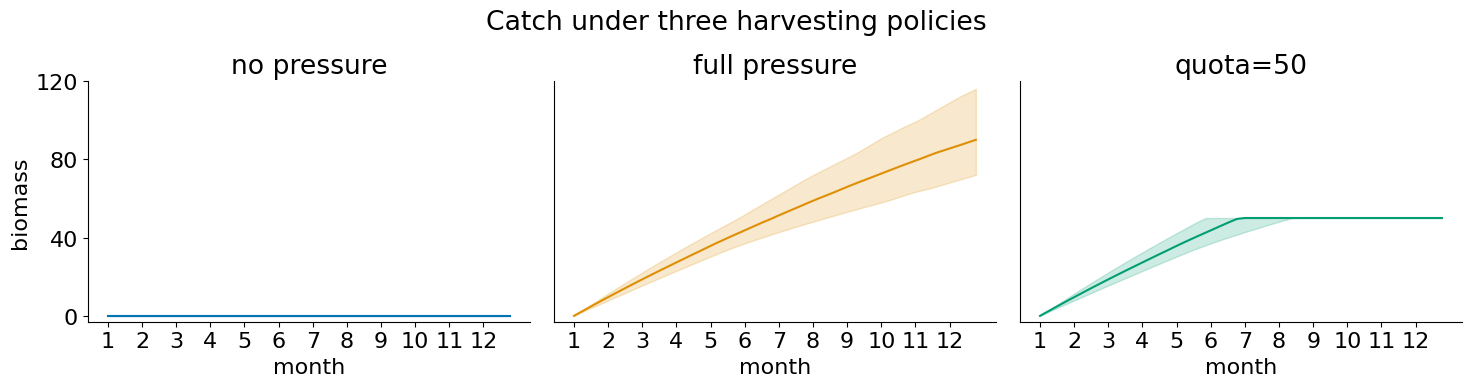

In [27]:
# paper figure with catch trajectories

catch_fig, catch_ax = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

catch_ax = catch_ax.flatten()

ylim = (-3, 117)

key = "catch_intermediate"

catch_ax[0].plot(
    logging_times,
    no_pressure_samples_medians[f"{key}_no_pressure"],
    label=f"{key}_no_pressure",
    color=colors[0],
)

catch_ax[0].set_title(f"no pressure")
catch_ax[0].fill_between(
    logging_times,
    no_pressure_samples_lows[f"{key}_no_pressure"],
    no_pressure_samples_highs[f"{key}_no_pressure"],
    alpha=0.2,
    color=colors[0],
)


catch_ax[0].set_xlabel("month")
catch_ax[0].set_ylabel("biomass")


catch_ax[1].plot(
    logging_times,
    pressure_samples_medians[f"{key}_pressure"],
    label=f"{key}_pressure",
    color=colors[1],
)

catch_ax[1].set_title(f"full pressure")
catch_ax[1].fill_between(
    logging_times,
    pressure_samples_lows[f"{key}_pressure"],
    pressure_samples_highs[f"{key}_pressure"],
    alpha=0.2,
    color=colors[1],
)


catch_ax[1].set_xlabel("month")


for i in range(3):
    catch_ax[i].set_ylim(ylim)
    yticks = np.linspace(*ylim, 4).round(0) + 3
    catch_ax[i].set_yticks(yticks)
    catch_ax[i].set_xticks(x_ticks)
    catch_ax[i].set_xticklabels(x_labels)


catch_ax[2].plot(
    logging_times,
    dependend_50_samples_medians[f"{key}_dependent_50.0"],
    label=f"{key}_dependent_50.0",
    color=colors[2],
)
catch_ax[2].set_title(f"quota=50")
catch_ax[2].fill_between(
    logging_times,
    dependend_50_samples_lows[f"{key}_dependent_50.0"],
    dependend_50_samples_highs[f"{key}_dependent_50.0"],
    alpha=0.2,
    color=colors[2],
)

catch_ax[2].set_xlabel("month")

for i in (1, 2):
    catch_ax[i].tick_params(axis="y", left=False, labelleft=False)


catch_fig.tight_layout()

sns.despine()

catch_fig.suptitle(
    "Catch under three harvesting policies",
)
catch_fig.subplots_adjust(top=0.8)
catch_fig.show()

catch_fig.savefig("figures/catch_trajectories.pdf", dpi=300)

## - [Probabilities of causation](#probabilities-of-causation)


We now aim to demonstrate how probabilities of causation can be computed within the framework. The formal definitions of the probabilities of causation were originally provided by Pearl (1999). These queries are traditionally defined for binary treatment $X$ and outcome $Y$ variables — we enumerate those binary definitions here, and then develop some intuition. Later, in the context of our fishery management example, we will expand to the non-binary setting, largely following Kawakami et al. 2024.


Let $X, Y$ be binary variables within a structural causal model $M$, and let $x$, $x'$, $y$, $y'$, denote the propositions $X=1$, $X=0$, $Y=1$, $Y=0$ respectively. Denote by $Y_x$ and $Y_{x'}$ the counterfactual outcomes obtained by performing the do-interventions $X=1)$ and $X=0$.\footnote{The canonical intervention $X_i=x_i$ fixes the structural equation for $X_i$ to a constant. The probabilities of causation, then, are defined as follows:
\begin{align}
    PN(x,y) &\coloneqq P(Y_{x'} = 0 \mid x, y), \\
    PS(x,y) &\coloneqq P(Y_{x} = 1 \mid x', y'), \\
    PNS(x,y) &\coloneqq P(Y_{x} = 1, Y_{x'} = 0).
\end{align}
$PN(x,y)$ quantifies the probability that $x$ was necessary to produce outcome $y$; $PS(x,y)$ quantifies the probability that $x$ alone would suffice to produce $y$; and $PNS(x,y)$ jointly quantifies the event that $x$ is both necessary and sufficient for outcome $y$.

To compute the probability of necessity, we consider only (condition on) worlds where the events $x$ and $y$ occurred, and then evaluate the probability of $Y$ being false if we intervene to make $X$ false. Similarly, the capacity to produce an outcome — the probability of sufficiency — is computed by conditioning on $X$ and $Y$ being false, and evaluating the probability of $Y$ being true if we now intervene to make $X$ true. A notion balancing the dimensions of necessity and sufficiency is the probability of necessity and sufficiency, which is \emph{not} a function of the separate probabilities. To evaluate $PNS$, we do \emph{not} condition either way. but rather evaluate the probability that both intervening to make $X$ true results in $Y_{x}=1$ and intervening to make $X$ false results in $Y_{x'}=1$. Notice that in the case of PNS, any conditioning here would bias the outcome. Suppose $X$ and $Y$ are causally disconnected. If you condition on $x,y$, you make $Y_x$ true by default, and if you condition on $x', y'$, you make $Y_{x'}$ false, effectively making one of the components satisfied for free, which is undesirable.

Using these notions in the context of systems with continuous time and state brings a new challenge, as now seemingly straightforward natural language binary predicates require careful explications (probabilities of causation for non-binary treatments and outcomes have been studied by Li & Pearl 2024, Kawakami et al. 2024). In this context, both the biomass outcome and the TAC quota are scalar valued, however, so we employ the contrastive definitions similar to thse in Def.~3.1 of Kawakami 2024. The binary outcome we are interested in is whether the intermediate biomass remains above a reference point $\gamma = 130$ units at the end of the year. In practice, this reference point is typically taken to be the biomass level affording ``maximum sustainable yield'' (MSY) (Anon 1976), but sometimes alternatives are used (Ortiz et al. 2010). For all three notions, we assume that, in the factual world, a TAC with quota $q_1$ was implemented, and stakeholders wish to contrast it with an alternative TAC quota of $q_2$.

- $\textsf{necessity:}$ in the factual world ($q_1$), we succeeded. Conditioning on this information, what is the probability that we would have failed had we used quota $q_2$ instead?
- $\textsf{sufficiency:}$ in the factual worked ($q_1$), we failed. Conditioning on this information, what is the probability that we would have succeeded had we used quota $q_2$.
- $\textsf{necessity and sufficiency:}$ using the system as is, without any further conditioning, what is the probability that both (1) if we use $q_1$ we succeed and (2) if we use $q_2$ we fail?


In [28]:
threshold = torch.tensor(130.0)


def causation_probabilities_from_outcomes(
    outcome_factual: torch.Tensor,
    outcome_counterfactual: torch.Tensor,
    threshold: torch.Tensor = threshold,
):

    # ---------
    # necessity

    mask_nec = outcome_factual > threshold
    outcome_nec = outcome_counterfactual[mask_nec]

    prob_nec = (outcome_nec <= threshold).float().mean()
    # -------

    # ------
    # sufficiency

    mask_suff = outcome_factual <= threshold
    outcome_suff = outcome_counterfactual[mask_suff]

    prob_suff = (outcome_suff > threshold).float().mean()
    # ------

    # ------
    # necessity and sufficiency

    # no masking, as no conditioning
    # evaluate frequency of (Y in q) and (Y' in baseline)
    prob_nec_suff = (
        ((outcome_factual < threshold) * (outcome_counterfactual >= threshold))
        .float()
        .mean()
    )

    # ------

    return {
        "nec": prob_nec,
        "suff": prob_suff,
        "nec_suff": prob_nec_suff,
        "outcome_factual": outcome_factual,
        "outcome_counterfactual": outcome_counterfactual,
    }


def causation_probabilities_from_quota(
    dependent_samples: Dict,
    factual_quota: float,
    counterfactual_quota: float,
    threshold=threshold,
):

    outcome_counterfactual = dependent_samples[counterfactual_quota][
        f"intermediate_dependent_{str(counterfactual_quota)}"
    ][:, -1]

    outcome_factual = dependent_samples[factual_quota][
        f"intermediate_dependent_{str(factual_quota)}"
    ][:, -1]

    return causation_probabilities_from_outcomes(
        outcome_factual, outcome_counterfactual, threshold
    )

We compute the relevant probabilities for all quota from the grid that we used for sampling.

In [29]:
quota_list = [float(x) for x in range(0, 121, 5)]
probabilities_of_necessity = np.zeros((len(quota_list), len(quota_list)))
probabilities_of_sufficiency = np.zeros((len(quota_list), len(quota_list)))
probabilities_of_necessity_and_sufficiency = np.zeros(
    (len(quota_list), len(quota_list))
)
indices_df = pd.DataFrame(index=quota_list, columns=quota_list)


for i, quota_i in enumerate(quota_list):
    for j, quota_j in enumerate(quota_list):
        causation_dictionary = causation_probabilities_from_quota(
            dependent_samples=dependent_samples,
            factual_quota=quota_i,
            counterfactual_quota=quota_j,
        )

        probabilities_of_necessity[j, i] = causation_dictionary["nec"]
        probabilities_of_sufficiency[j, i] = causation_dictionary["suff"]
        probabilities_of_necessity_and_sufficiency[j, i] = causation_dictionary[
            "nec_suff"
        ]
        indices_df.iloc[j, i] = (quota_j, quota_i)

### - [Probabilities of Causation Total Allowable Catch (TAC) Quotas](#probabilities-of-causation-total-allowable-catch-tac-quotas)


In Step 1 in the example narrative, within the first year of commercial fishing, the fishery has no quota (here it is enough to set it to $q=120$, which is never met),  and falls below sustainable biomass. Conditioning on this failure, the regulators seek an intervention with a high probability of changing this outcome next time along the counterfactual dimension. They implement a strict TAC of $30$, evaluating the probability of sufficiency (the probability of achieving sustainable biomass above the desired threshold of 130) to be 0.87.

/tmp/ipykernel_97163/3287275338.py:233: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


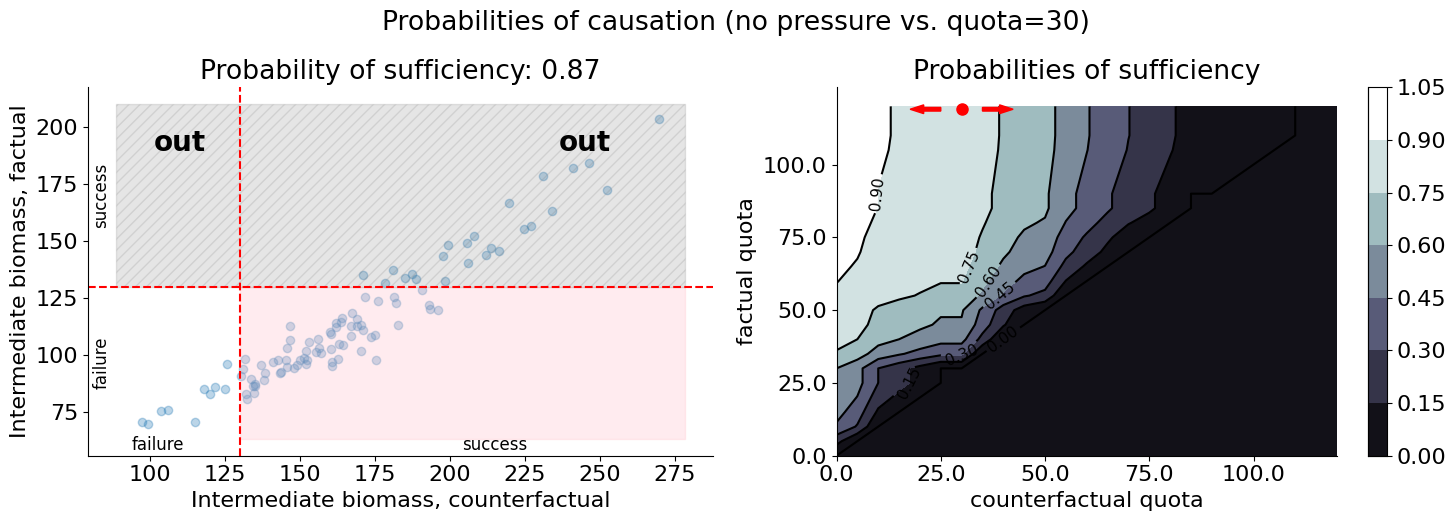

In [30]:
step1 = plot_causation_pair(
    factual_quota=120,
    counterfactual_quota=30,
    postfix="(no pressure vs. quota=30)",
    type="sufficient",
    dot_coordinates=(6, 23.8),
    fig_path="figures/causation_120_30_step1.pdf",
)

Step 2 in the example narrative. The season ran with a TAC of $30$ units, and the intermediate biomass target reference limit ($\gamma=130$) was met. Conditioning on this, parties interested in increasing the fishing quota ask whether such a low TAC was \textit{necessary}. They seek an alternative quota along the counterfactual dimension that, when contrasted with the factual TAC of $30$, reveals the factual TAC as probably unnecessary. As a counterexample, they choose a TAC of $50$, which yields a relatively low probability of necessity ($.18$).

/tmp/ipykernel_97163/3287275338.py:233: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


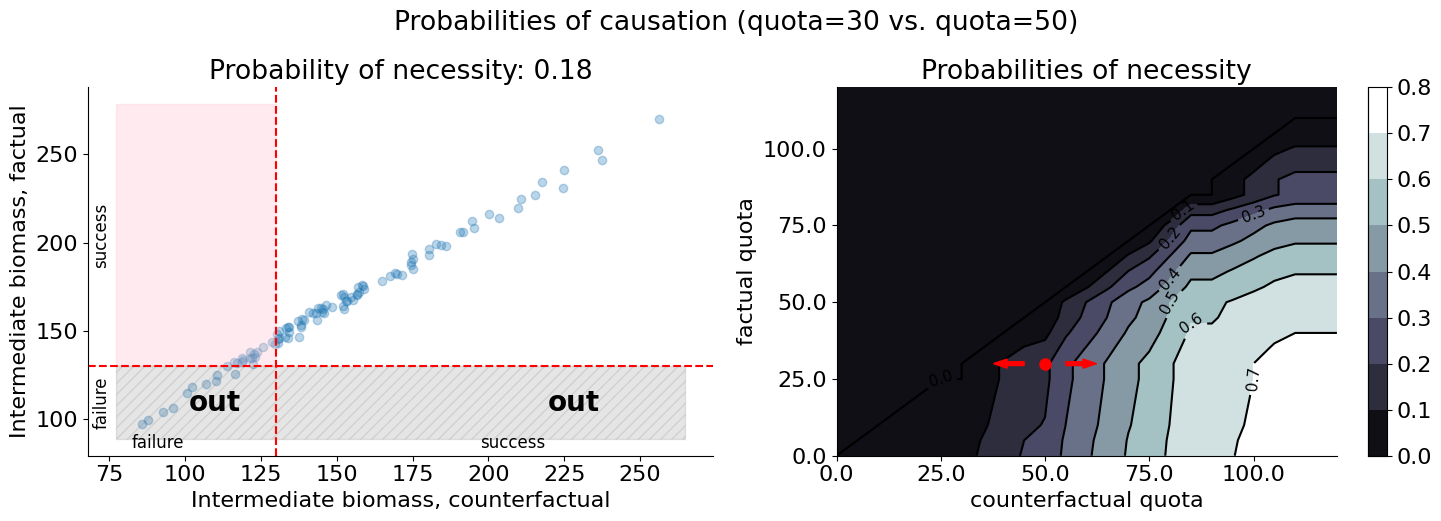

In [31]:
plot_causation_pair(
    factual_quota=30,
    counterfactual_quota=50,
    postfix="(quota=30 vs. quota=50)",
    fig_path="figures/causation_30_50_step2.pdf",
    type="necessary",
    dot_coordinates=(10, 6),
)

Step 3 in the example narrative. This time, before the season starts and prior to seeing what the outcome will be, both sides aim to find a quota with a large probability of both necessity and sufficiency. They contrast proposed TAC quotas with a baseline, status quo TAC of $120$ units (never met). They notice that the probability surface flattens out above $.60$, meaning further improvement in the probability of necessity and sufficiency would require excessive limitations in quota. Ultimately, they agree on a quota that results in a value above $0.6$, i.e., a TAC quota of $0.35$.

/tmp/ipykernel_97163/3287275338.py:233: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


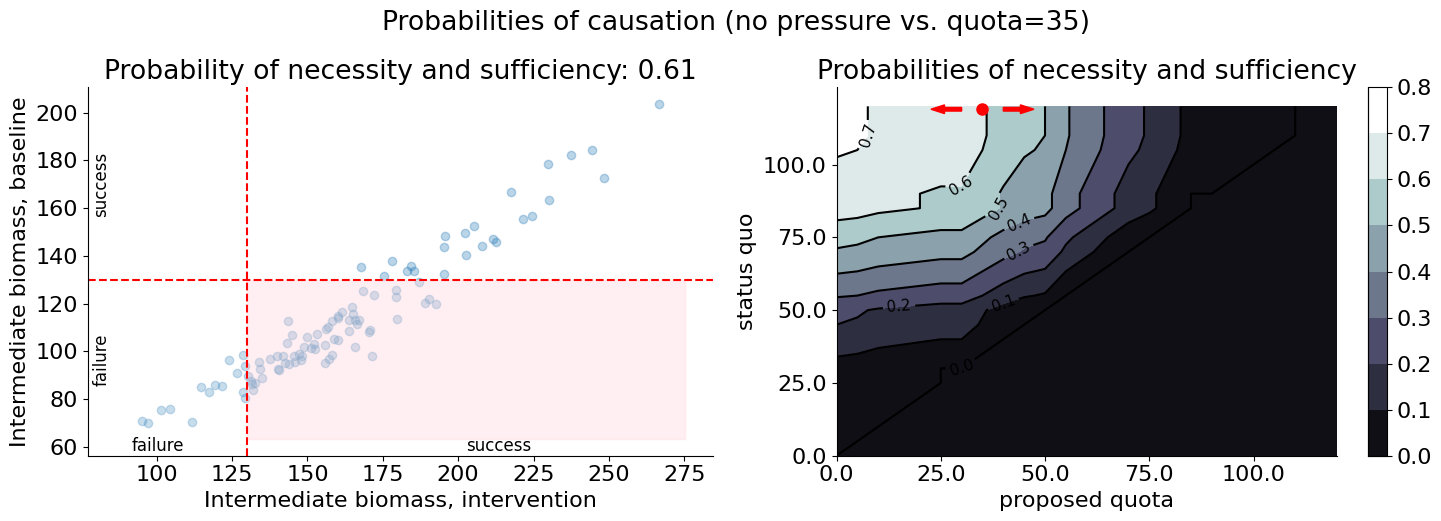

In [32]:
plot_causation_pair(
    factual_quota=120,
    counterfactual_quota=35,
    postfix="(no pressure vs. quota=35)",
    dot_coordinates=(7, 23.8),
    fig_path="figures/causation_120_35_step3.pdf",
    type="sufficient and necessary",
)

### - [Probability of Necessity of State-Dependent Intervention Timing](#probability-of-necessity-of-state-dependent-intervention-timing)


Queries about the probabilities of causation, such as "was $X$ necessary to achieve $Y$", are ambiguous when a real world event $X=x$ is multi-faceted and potential alternative actions are plentiful. We will define our event of interest as involving the time at which an intervention occurs. We can make this precise by constructing twin worlds using the tools provided in this paper — particularly by additionally employing the static intervention.

Consider worlds where the season ends before some time $\lambda$, and biomass goal $\gamma$ is achieved at a later time $\tau$ (for instance, at the end of the year). Fishery managers wonder whether they might fail to meet their biomass goals if, contrary to fact in those cases, the season ends at or after time $\lambda$. The relevant question is: was ending the season at or before time $\lambda$ necessary for achieving the biomass goal? We can answer this question by asking a probability of necessity query. Unlike before, however, the causal attribution question relates to the time at which the intervention occurs and is still conditional on the intervention's time under a state-dependent interventional policy. Consider the following binary predicates, where $T(\varphi_{q_1})$ extracts the time at which the season ends due to the TAC quota $q_1$
$$
    X = \mathbb{I}\left[T(\varphi_{q_1}) < \lambda\right];\qquad Y=\mathbb{I}\left[\textnormal{b}_{q_1}^\tau \geq \gamma\right]
$$
Recall that the probability of necessity is $P(Y_{X=0} = 0 \mid X=1, Y=1)$ with shorthand $P(y'_{x'}\mid x, y)$. To coherently characterize this in our example, we must define what it means to perform the intervention $X=0$. Given our definition of the predicate $X$ above, $X=0$ suggests an intervention that results in a world where the season ends at or after $\lambda$, with all else (such as the noise or the resulting fishing pressure of 0) remaining equal. Importantly, there are many such worlds, which means the probability of necessity must adopt an existential flavor: "under exogenous noise where $X=1$ and $Y=1$, what is the probability that all worlds consistent with intervention $X=0$ fail to meet the outcome?" To precisely define this set of interventional worlds, we consider a twin world under a static intervention occurring at some time $\lambda' \geq \lambda$, but with the same interventional jump map.

The trigger dynamics of the state-dependent intervention can also be considered a sort of ``treatment mechanism'' determining the time at which a static intervention occurs. By constructing a world where direct control over the intervention timing is possible, we are able to disentangle these mechanisms. 
$$
    Y_{do(X=0)} = 0 \iff \mathbb{I}\left[\textnormal{b}_{\lambda'}^\tau < \gamma \right]\  
    \forall \lambda' \geq \lambda
$$

Note that if $\textnormal{b}_{\lambda'}^\tau$ monotonically decreases as $\lambda' \rightarrow \infty$, then we can equivalently write the event $y'_{x'}$ as $\mathbb{I}\left[\textnormal{b}_{\lambda'}^\tau < \gamma\right]$. Indeed, under our model and distributions on the intial state and system parameters, and so we can finally precisely express the probability that ending the season before time $\lambda$ is causally necessary to achieve the biomass outcome:
$$
    P(y'_{x'}\mid x, y) = P(\mathbb{I}\left[\textnormal{b}_{\lambda'}^\tau < \gamma \right]\ \mid \mathbb{I}\left[T(\varphi_{q_1})\leq \lambda\right], \mathbb{I}\left[\textnormal{b}_{q_1}^\tau \geq \gamma\right])
$$

Unlike in the previous case, conditioning on the factual interventional event is required, because knowing that the season ended before $\lambda$  carries information about the model parameters: the earlier the TAC quota is met (at times prior to $\lambda$), the faster the catch rates. Faster catch rates stem from some combination of higher fishing pressure, higher initial biomass, higher growth rates, etc., all of which influence whether the biomass target will be achieved under alternative season-ending times, even after conditioning on success in the factual world. In other words, we do not necessarily have exogeneity here: $Y_{x} \cancel \perp X$; $Y_{x'} \cancel \perp X$. This further aligns with understanding the state-dependent trigger dynamics as a sort of treatment mechanism. Exogeneity, here, is violated because the random initial states and parameters can be considered ``parents'' of both $X$ and $Y$. In violating exogeneity, non-parametric identification results for this example may be out of reach.

Returning to the example, suppose we consider a range over fixed threshold $\lambda$, approximated by a finite grid $(\lambda_i)$. For each $\lambda_i$, we (1) condition on the season ending before $\lambda_i$ and on the intermediate biomass at $\tau$  being above $\gamma$, and (2) intervene so that the end of the season occurs at $\lambda_i$ (and not earlier). The relevant probability of necessity query is whether intervening before $\lambda_i$ was necessary for the success. That is, for each such $\lambda_i$ we inspect the posterior predictive distribution of the intermediate biomass at $\tau$  under the intervention, and inspect the probability that this outcome is below $\gamma$.


In [34]:
intervention_grid_size = 30
threshold = torch.tensor(130.0)
quota = {"catch_intermediate_dependent": 40.0}


def TOE_dynamics(
    num_samples,
    intervention_grid_size,
    threshold=threshold,
    quota=quota,
    minimal_cutoff_point=torch.tensor(0.3),
):

    noise_keys = ["r1", "r2", "r3", "d1", "d2", "m3", "k1", "p12", "p23", "e12", "e23"]

    def internal_dynamics():

        shared_noise = sample_fishery_priors()

        fish_dynamics_state_dependent = FishDynamics(
            params=shared_noise, postfix="dependent"
        )

        with TorchDiffEq(), LogTrajectoryAndInterventionTime(
            logging_times, is_traced=True
        ) as lt_dependent:
            with DynamicIntervention(
                event_fn=stop_fishing_policy(quota), intervention=season_ends
            ):
                simulate(
                    fish_dynamics_state_dependent,
                    INITIAL_STATE_DEPENDENT,
                    start_time,
                    logging_times[-1],
                )

    dynamical_predictive = Predictive(
        internal_dynamics,
        num_samples=num_samples,
    )
    dynamical_samples = dynamical_predictive()

    grabbed_noise = {key: dynamical_samples[key] for key in noise_keys}

    season_ends_static = {
        key.replace("_dependent", "_static"): season_ends[key]
        for key in season_ends.keys()
    }

    # conditioning mask
    outcome_above_threshold_mask = (
        dynamical_samples["intermediate_dependent"][:, -1] > threshold
    )

    intervention_times = torch.linspace(minimal_cutoff_point, 1, intervention_grid_size)
    intervened_outcomes = torch.zeros((num_samples, intervention_grid_size - 1))
    joint_masks = []
    intervened_intermediates = []
    intervened_catches = []  # bad English, think of a better plural:)

    for intervention_index in range(intervention_grid_size - 1):
        intervention_time = intervention_times[intervention_index]
        print("Processing lambda: ", intervention_time.item())

        intervention_applied_mask = (
            dynamical_samples["interruption_time"] < intervention_time
        )

        joint_mask = outcome_above_threshold_mask * intervention_applied_mask
        joint_masks.append(joint_mask)

        def static_runs():
            shared_noise = sample_fishery_priors()  # will be overriden
            fish_dynamics_static = FishDynamics(params=shared_noise, postfix="static")

            with MultiWorldCounterfactual() as mwc:
                with StaticIntervention(
                    time=intervention_time, intervention=season_ends_static
                ):
                    with TorchDiffEq(), LogTrajectory(
                        logging_times, is_traced=True
                    ) as lt_static:
                        simulate(
                            fish_dynamics_static,
                            INITIAL_STATE_STATIC,
                            start_time,
                            logging_times[-1],
                        )

            catch = lt_static.trajectory["catch_intermediate_static"].squeeze()
            intermediate = lt_static.trajectory["intermediate_static"].squeeze()

            intervened_catch = pyro.deterministic("intervened_catch", catch[1, 1, 1, :])

            intervened_intermediate = pyro.deterministic(
                "intervened_intermediate", intermediate[1, 1, 1, :]
            )
            intervened_outcome = pyro.deterministic(
                "intervened_outcome", intervened_intermediate[..., -1]
            )

        predictive_static = Predictive(
            static_runs,
            num_samples=1,
        )

        with do(actions=grabbed_noise):
            static_samples = predictive_static()

        assert torch.allclose(static_samples["r1"], grabbed_noise["r1"])

        intervened_outcomes[:, intervention_index] = static_samples[
            "intervened_outcome"
        ]
        intervened_intermediates.append(static_samples["intervened_intermediate"])
        intervened_catches.append(static_samples["intervened_catch"])

    intervention_times = intervention_times[..., :-1]

    return (
        intervened_intermediates,
        intervened_catches,
        intervened_outcomes,
        intervention_times,
        joint_masks,
    )

In [35]:
pyro.clear_param_store()
torch.manual_seed(42)
pyro.set_rng_seed(42)

intervened_intermediates, intervened_catches, intervened_outcomes, intervention_times, joint_masks = TOE_dynamics(
    num_samples=num_toe_samples, intervention_grid_size=intervention_grid_size
)

Processing lambda:  0.30000001192092896
Processing lambda:  0.32413795590400696
Processing lambda:  0.3482758700847626
Processing lambda:  0.3724138140678406
Processing lambda:  0.3965517282485962
Processing lambda:  0.4206896722316742
Processing lambda:  0.4448275864124298
Processing lambda:  0.4689655303955078
Processing lambda:  0.4931034445762634
Processing lambda:  0.5172414183616638
Processing lambda:  0.5413793325424194
Processing lambda:  0.565517246723175
Processing lambda:  0.5896551609039307
Processing lambda:  0.613793134689331
Processing lambda:  0.6379310488700867
Processing lambda:  0.6620689630508423
Processing lambda:  0.6862068772315979
Processing lambda:  0.7103448510169983
Processing lambda:  0.7344827651977539
Processing lambda:  0.7586206793785095
Processing lambda:  0.7827585935592651
Processing lambda:  0.8068965673446655
Processing lambda:  0.8310344815254211
Processing lambda:  0.8551723957061768
Processing lambda:  0.8793103694915771
Processing lambda:  0.903

Let's plot our results. For each $\lambda_i$ from a grid of intervention times (1) we  condition on the season ending before $\lambda_i$ and on the successful outcome, and (2) we intervene so that the end of the season occurs at $\lambda_i$. (top) Estimated probabilities of necessity of interventions before 
    $\lambda_i$, (bottom) Posterior samples of intermediate biomass at $\tau$.

In [36]:
timewise_probabilities = []
masked_outcomes = []

for i in range(1, intervention_grid_size - 1):
    joint_mask = joint_masks[i]
    masked_outcome = intervened_outcomes[joint_mask, i]
    masked_outcomes.append(masked_outcome)
    timewise_probabilities.append((masked_outcome < threshold).float().mean())

assert len(timewise_probabilities) == intervention_times.shape[0] - 1

# glue together two neighbors to decrease the number of violins
violin_outcomes = []
violin_unconditioned = []
violin_times = []
indices = range(intervention_grid_size - 1)[::2][1:]

for i in indices[:-1]:
    violin_outcomes.append(
        torch.flatten(torch.cat((masked_outcomes[i], masked_outcomes[i + 1])))
    )

    violin_times.append(intervention_times[i + 1].item())

    violin_unconditioned.append(
        torch.flatten(
            torch.cat((intervened_outcomes[:, i], intervened_outcomes[:, i + 1]))
        )
    )

In [37]:
days = [(time * 365.25) for time in violin_times]
start_date = datetime(2024, 1, 1)
actual_dates = [start_date + timedelta(days=day) for day in days]

x_calendar_labels = [date.strftime("%m-%d") for date in actual_dates]
x_calendar_labels = [date.strftime("%b %d") for date in actual_dates]

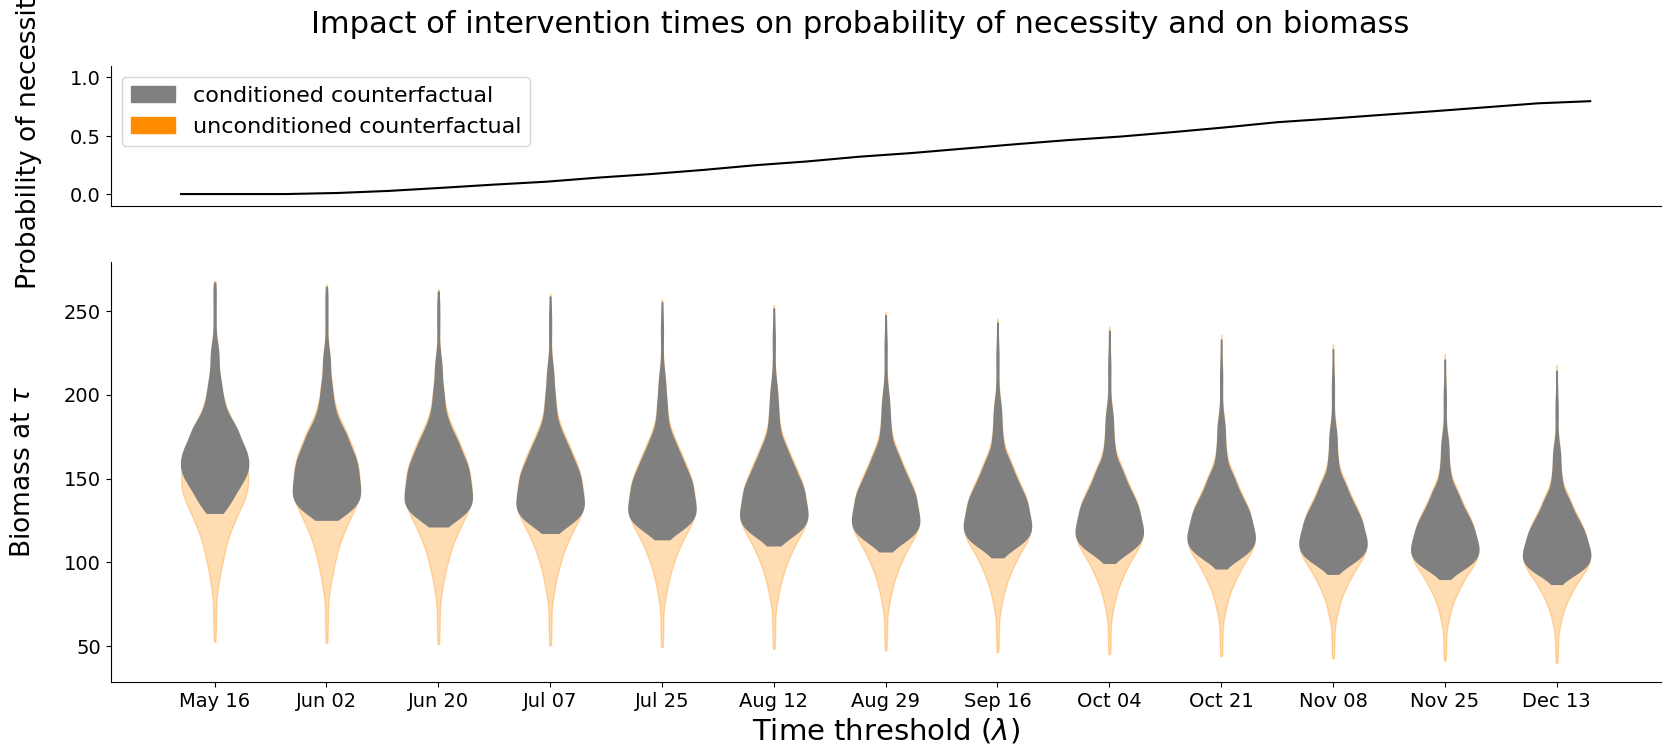

In [38]:
# plotting results

fig, ax = plt.subplots(2, 1, figsize=(20, 8), gridspec_kw={"height_ratios": [1, 3]})
axes = ax.flatten()

ax1 = axes[1]
ax2 = axes[0]

ax2.plot(timewise_probabilities, color="black", label="probability of necessity")
ax2.set_ylabel("Probability of necessity", color="black", labelpad=20, fontsize=19)
ax2.tick_params(axis="y", labelsize=14)
ax2.set_ylim(-0.1, 1.1)
ax2.set_xticks([])


parts2 = ax1.violinplot(
    violin_unconditioned,
    showmeans=False,
    widths=0.6,
    showextrema=False,
    showmedians=False,
    points=500,
)

parts = ax1.violinplot(
    violin_outcomes,
    showmeans=False,
    widths=0.6,
    showextrema=False,
    showmedians=False,
    points=500,
)


for pc in parts["bodies"]:
    pc.set_alpha(1)
    pc.set_color("gray")

for pc in parts2["bodies"]:
    pc.set_alpha(0.3)
    pc.set_color("darkorange")


x_ticks = range(1, 14)
x_labels = x_calendar_labels


ax1.set_xlabel("Time threshold ($\\lambda$)", fontsize=21)
ax1.set_ylabel("Biomass at $\\tau$", labelpad=20, fontsize=19)
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_labels, fontsize=14)
ax1.tick_params(axis="y", labelsize=14)

sns.despine()


red_patch = mpatches.Patch(color="gray", label="conditioned counterfactual")
blue_patch = mpatches.Patch(color="darkorange", label="unconditioned counterfactual")


ax[0].legend(handles=[red_patch, blue_patch])

fig.suptitle(
    "Impact of intervention times on probability of necessity and on biomass",
    fontsize=22,
    y=0.95,
)

plt.subplots_adjust(top=0.88)

plt_path = "figures/intervention_time_biomass_necessity.pdf"
fig.savefig(plt_path, dpi=300)
plt.show()

Samples from the Bayesian dynamics based on the system. With three examples
of the impact of season shutdown dates on the intermediate biomass.

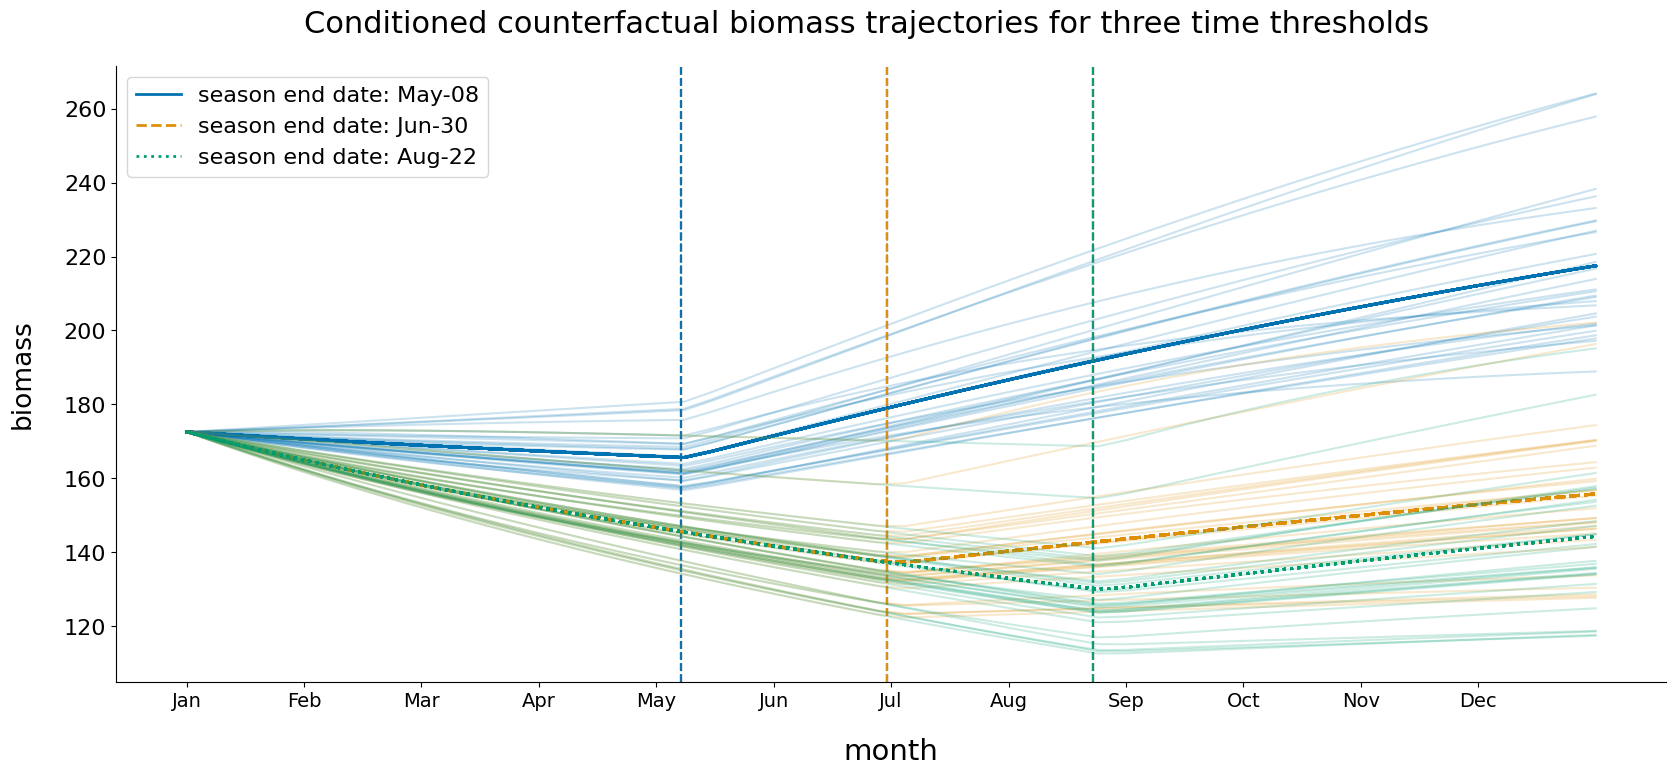

In [41]:
# spaghetti plot params ad auxiliaries

start_date = datetime(2024, 1, 2)
actual_dates = [
    start_date + timedelta(days=(30.44 * (month - 1))) for month in range(1, 13)
]
x_calendar_labels = [date.strftime("%b") for date in actual_dates]

line_steps = [2, 8, 14]


line_days = np.round(intervention_times * 365.25)[line_steps].numpy()
line_actual_days = [start_date + timedelta(days=day.item()) for day in line_days]
x_calendar_intervention_labels = [date.strftime("%b-%d") for date in line_actual_days]
x_ticks = list(range(0, 12))

month_axis = np.linspace(0, 12, 52)
max_lines = 30

colors = sns.color_palette("colorblind", n_colors=len(line_steps))

fig, ax = plt.subplots(
    1,
    1,
    figsize=(20, 8),
)

linetypes = ["solid", "dashed", "dotted"]

label = None
label_counter = 0
step = 0

for i, color in zip(line_steps, colors):

    masked_intermediates = intervened_intermediates[i][:, joint_masks[i], :].squeeze()
    max_lines = min(masked_intermediates.shape[0], max_lines)

    masked_internediates_mean = masked_intermediates.mean(dim=0)

    masked_catch = intervened_catches[i][:, joint_masks[i], :].squeeze()

    linetype = linetypes[step]

    for line in range(max_lines):

        if line == 0:
            label = f"season end date: {x_calendar_intervention_labels[label_counter]}"
            label_counter += 1
        else:
            label = None

        ax.plot(
            month_axis,
            masked_intermediates[line, :],
            color=color,
            alpha=0.2,
            label=None,
        )

        ax.plot(
            month_axis,
            masked_internediates_mean,
            color=color,
            alpha=1,
            linewidth=2,
            label=label,
            linestyle=linetypes[step],
        )

        ax.axvline(intervention_times[i] * 12.1, color=color, alpha=0.1, linestyle="--")

    step += 1


ax.set_xticks(x_ticks)
ax.set_xticklabels(x_calendar_labels, fontsize=14)
ax.legend()

ax.set_xlabel("month", fontsize=21, labelpad=20)
ax.set_ylabel("biomass", labelpad=20, fontsize=19)


sns.despine()


fig.suptitle(
    "Conditioned counterfactual biomass trajectories for three time thresholds",
    fontsize=22,
    y=0.95,
)


plt.subplots_adjust(top=0.88)

plt_path = "figures/intervention_time_biomass_trajectories.pdf"
fig.savefig(plt_path, dpi=300)
plt.show()

## References


Yuta Kawakami, Manabu Kuroki, and Jin Tian. Probabilities of causation for continuous and vector vari-
ables. In Negar Kiyavash and Joris M. Mooij (eds.), Proceedings of the fortieth conference on uncertainty
in artificial intelligence, volume 244 of Proceedings of machine learning research, pp. 1901–1921. PMLR,
July 2024. URL https://proceedings.mlr.press/v244/kawakami24a.html.

Judea Pearl. Probabilities Of Causation: Three Counterfactual Interpretations And Their Identifica-
tion. Synthese, 121(1/2):93–149, 1999. ISSN 00397857. doi: 10.1023/A:1005233831499. URL http:
//link.springer.com/10.1023/A:1005233831499.

S Zhou and Adm Smith. Effect of fishing intensity and selectivity on trophic structure and fishery production.
Marine Ecology Progress Series, 585:185–198, December 2017. ISSN 0171-8630, 1616-1599. doi: 10.3354/
meps12402. URL http://www.int-res.com/abstracts/meps/v585/p185-198/.
